### Imports

In [2]:
# system imports
import os, re
import sys
import json

# data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.animation as animation
import seaborn as sns

# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

# physionet data
import wfdb
from wfdb import processing

from biosppy.signals import ecg, hrv, ppg, acc
from scipy.interpolate import CubicSpline

### Global settings

In [10]:
# path settings
project_path = os.path.join(os.getcwd(), os.pardir)
data_path = os.path.join(project_path, 'data')
output_path = os.path.join(project_path, 'output')

# style settings
sns.set(style='whitegrid', rc={'axes.facecolor': '#EFF2F7'})

# sample frequency for Bobbi sensor
settings = {}
settings['fs'] = 500

identifiers = "s1_SHE_T1,s1_SHE_T2,s1_SHE_T3,s1_HE_T4,s1_HE_T5,s1_HE_T6,s2_HE_T1,s2_HE_T2,s2_HE_T3,s2_SHE_T4,s2_SHE_T5,s2_SHE_T6,s2_SHE_T7,s3_SHE_T1,s3_SHE_T2,s3_SHE_T3,s3_HE_T4,s3_HE_T5,s3_HE_T6,s4_HE_T1,s4_HE_T2,s4_HE_T3,s4_SHE_T4,s4_SHE_T5,s4_SHE_T6,s5_SHE_T1,s5_SHE_T2,s5_SHE_T3,s5_HE_T4,s5_HE_T5,s5_HE_T6,s6_HE_T1,s6_HE_T2,s6_HE_T3,s6_SHE_T4,s6_SHE_T5,s6_SHE_T6"
identifiers = [id[:-3] for id in  identifiers.split(",")]
identifiers = list(dict.fromkeys(identifiers))
print(identifiers)

['s1_SHE', 's1_HE', 's2_HE', 's2_SHE', 's3_SHE', 's3_HE', 's4_HE', 's4_SHE', 's5_SHE', 's5_HE', 's6_HE', 's6_SHE']


### Helper functions

In [4]:
def get_plot_ranges(start=10, end=20, n=5):
    '''
    Make an iterator that divides into n or n+1 ranges. 
    - if end-start is divisible by steps, return n ranges
    - if end-start is not divisible by steps, return n+1 ranges, where the last range is smaller and ends at n
    
    # Example:
    >> list(get_plot_ranges())
    >> [(0.0, 3.0), (3.0, 6.0), (6.0, 9.0)]

    '''
    distance = end - start
    for i in np.arange(start, end, np.floor(distance/n)):
        yield (int(i), int(np.minimum(end, np.floor(distance/n) + i)))

In [5]:
def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = label(np.diff(p) < threshold)
    print(np.diff(p))
    print(label(np.diff(p) < threshold))

    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output

In [6]:
def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity

## Load data

In [7]:
file_dir = "../Data/Sensors/"

def get_json_files(directory):
  json_files = []
  for root, _, files in os.walk(directory):
    for file in files:
      if file.endswith(".json"):
        json_files.append(os.path.join(root, file))
  return json_files

json_files_list = sorted(get_json_files(file_dir))

# Open and read the JSON file
def get_json_data (file_name):
    with open(file_name, 'r') as file:
        data = json.load(file)
        return data

def get_duration(data):
    total_duration = data[-1]['time'] 
    print(total_duration / 60)

## Explore data

7.858931534716673
(2, 42694)
7.743354950000017
(2, 46444)
14.858676585416712
(2, 89147)
14.498179815283342
(2, 86972)
9.37872825208336
(2, 25031)
16.04460655486667
(2, 96244)
25.433273893050014
(2, 152485)


KeyboardInterrupt: 

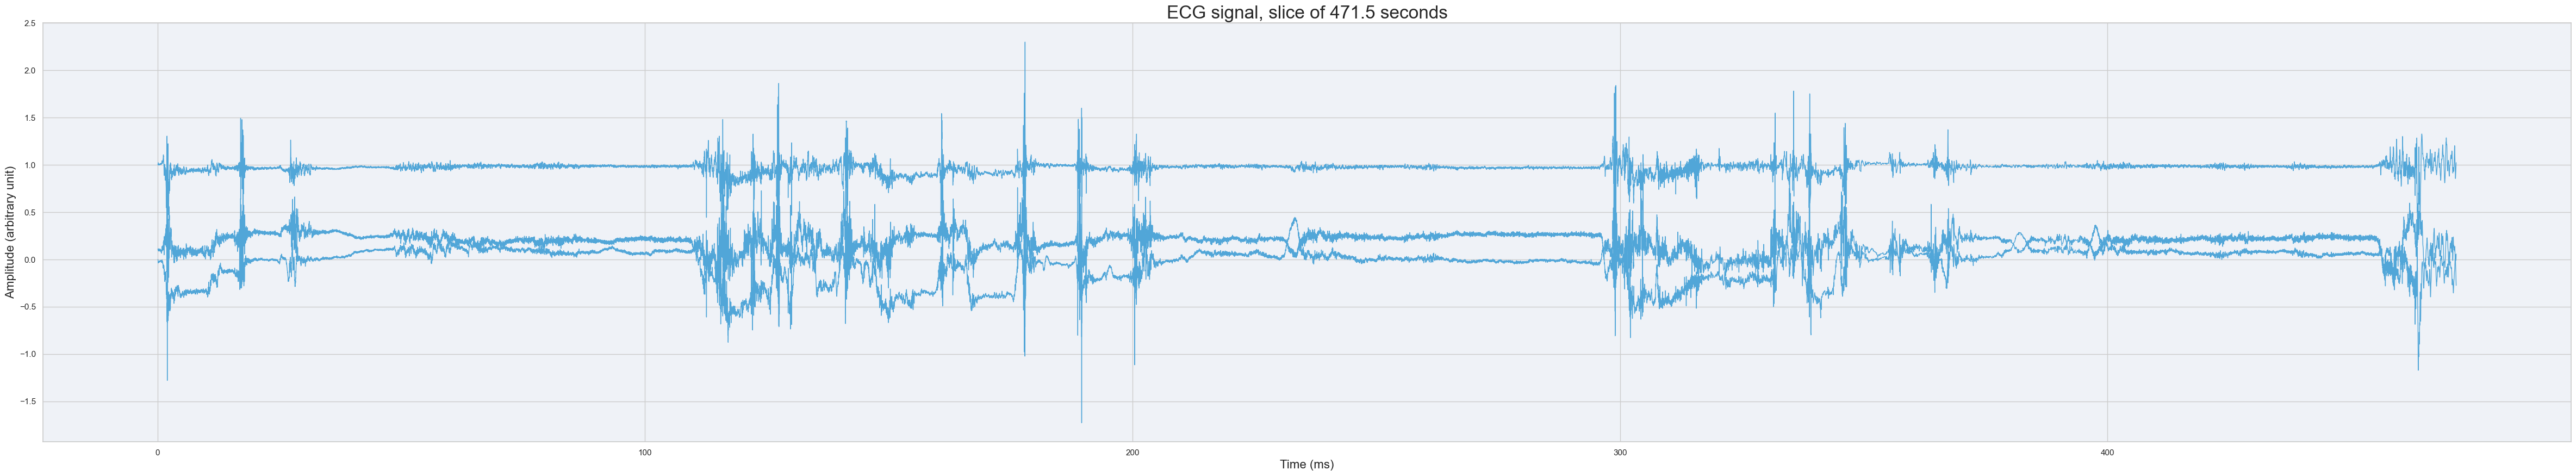

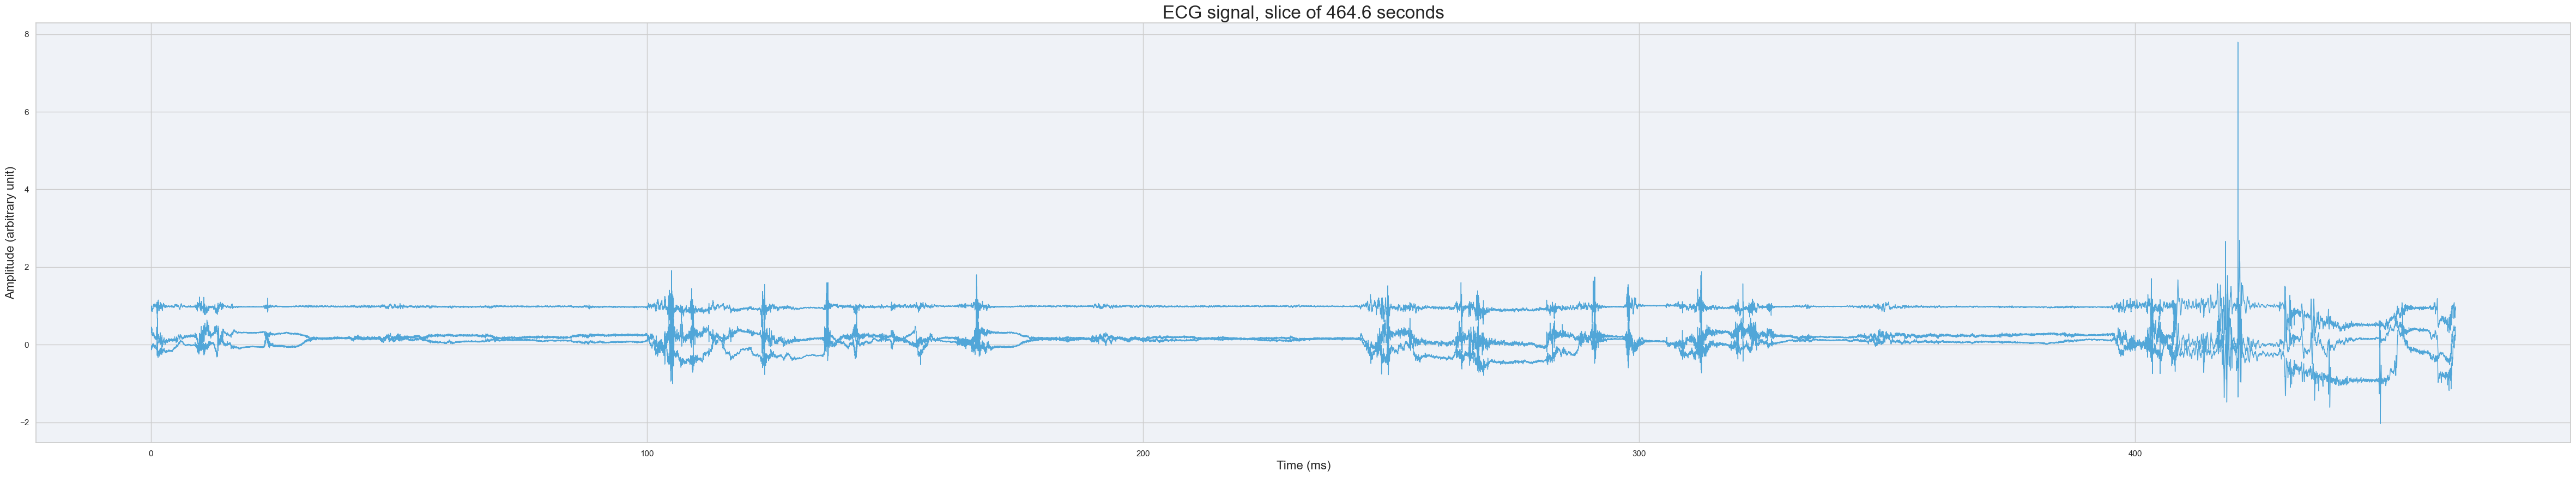

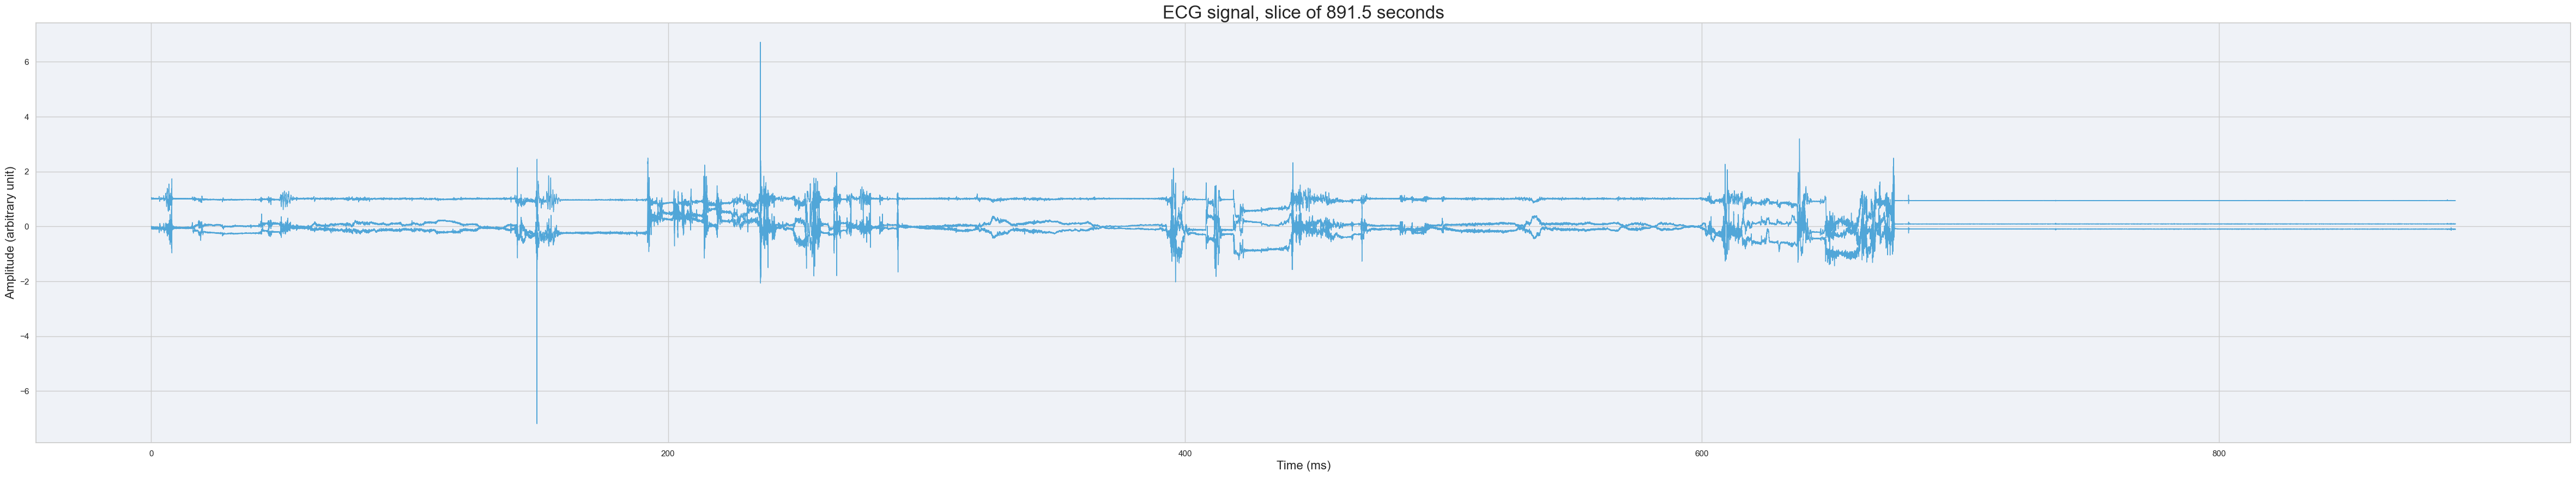

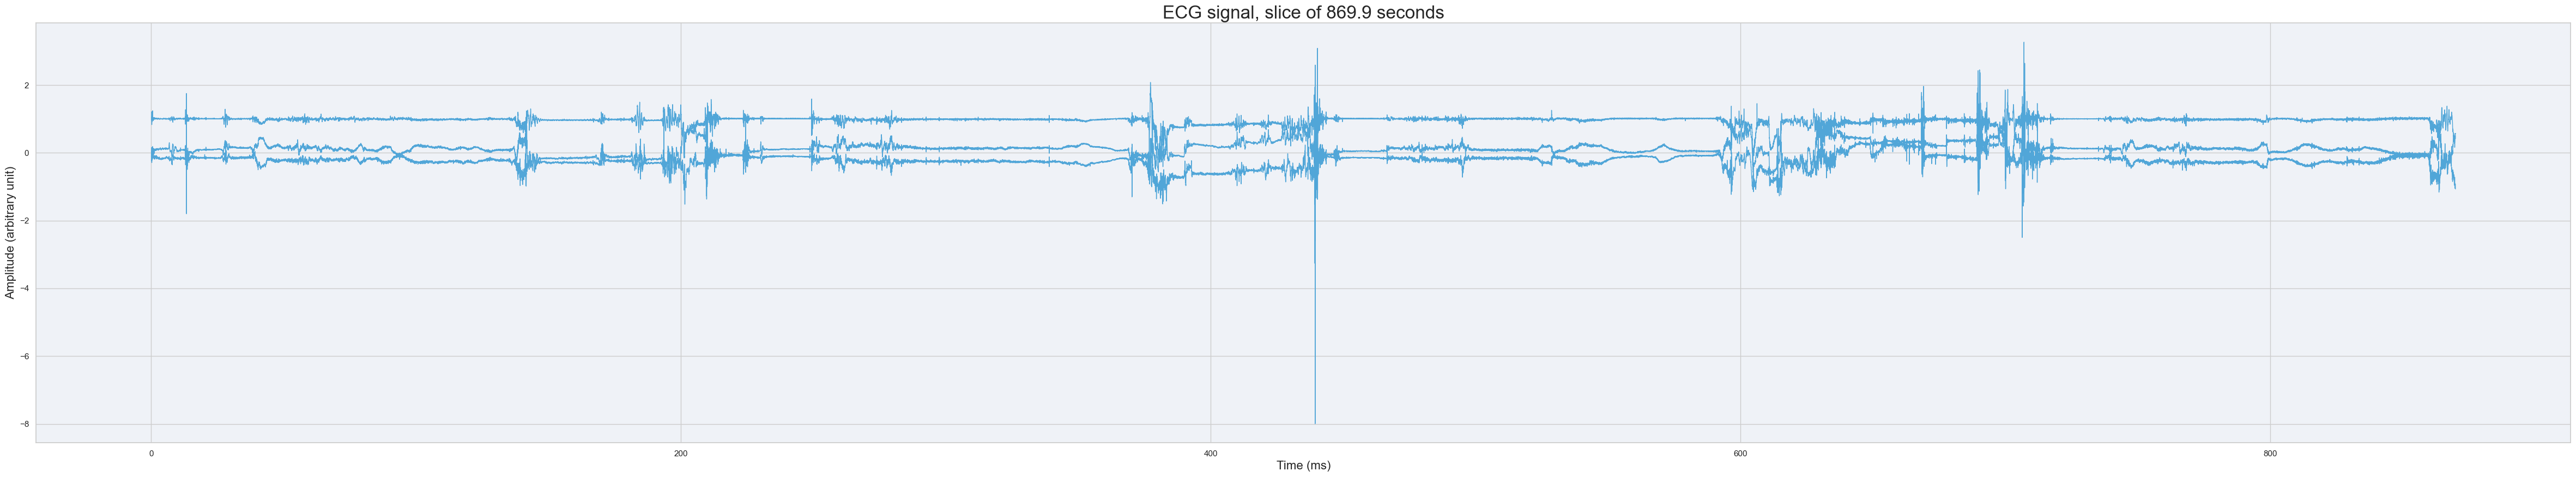

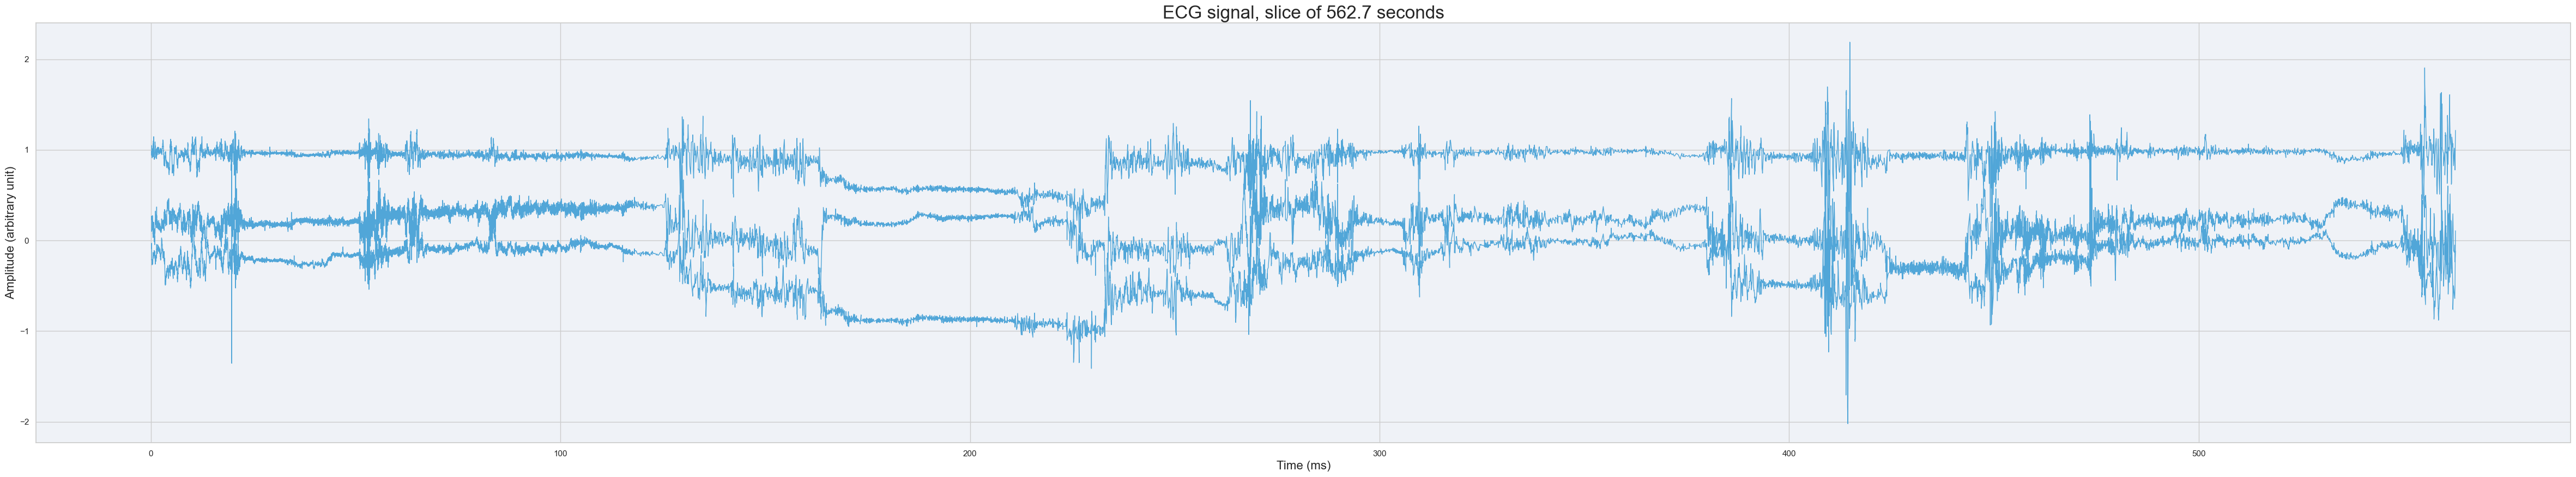

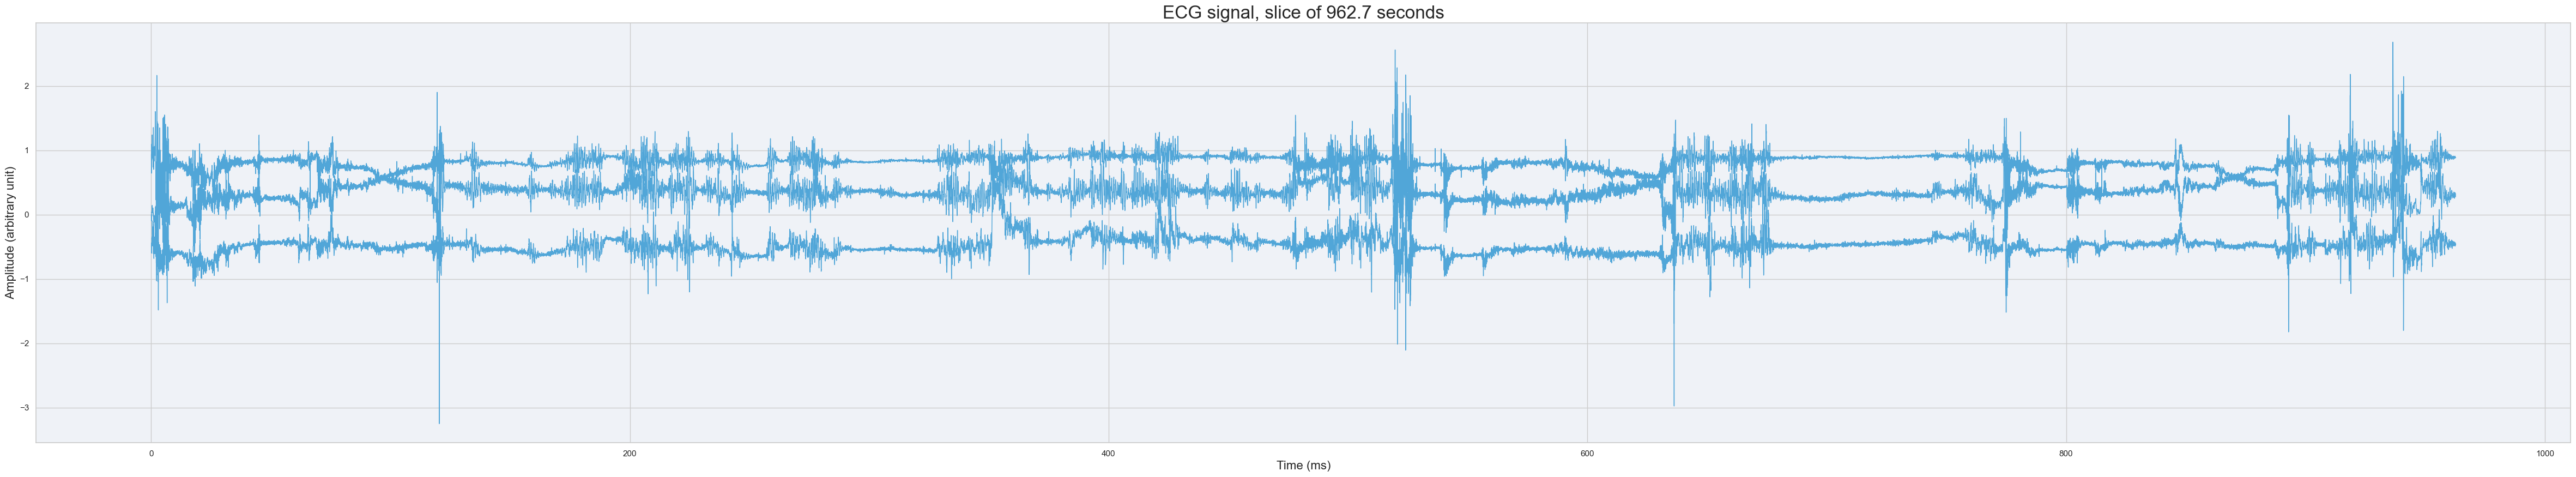

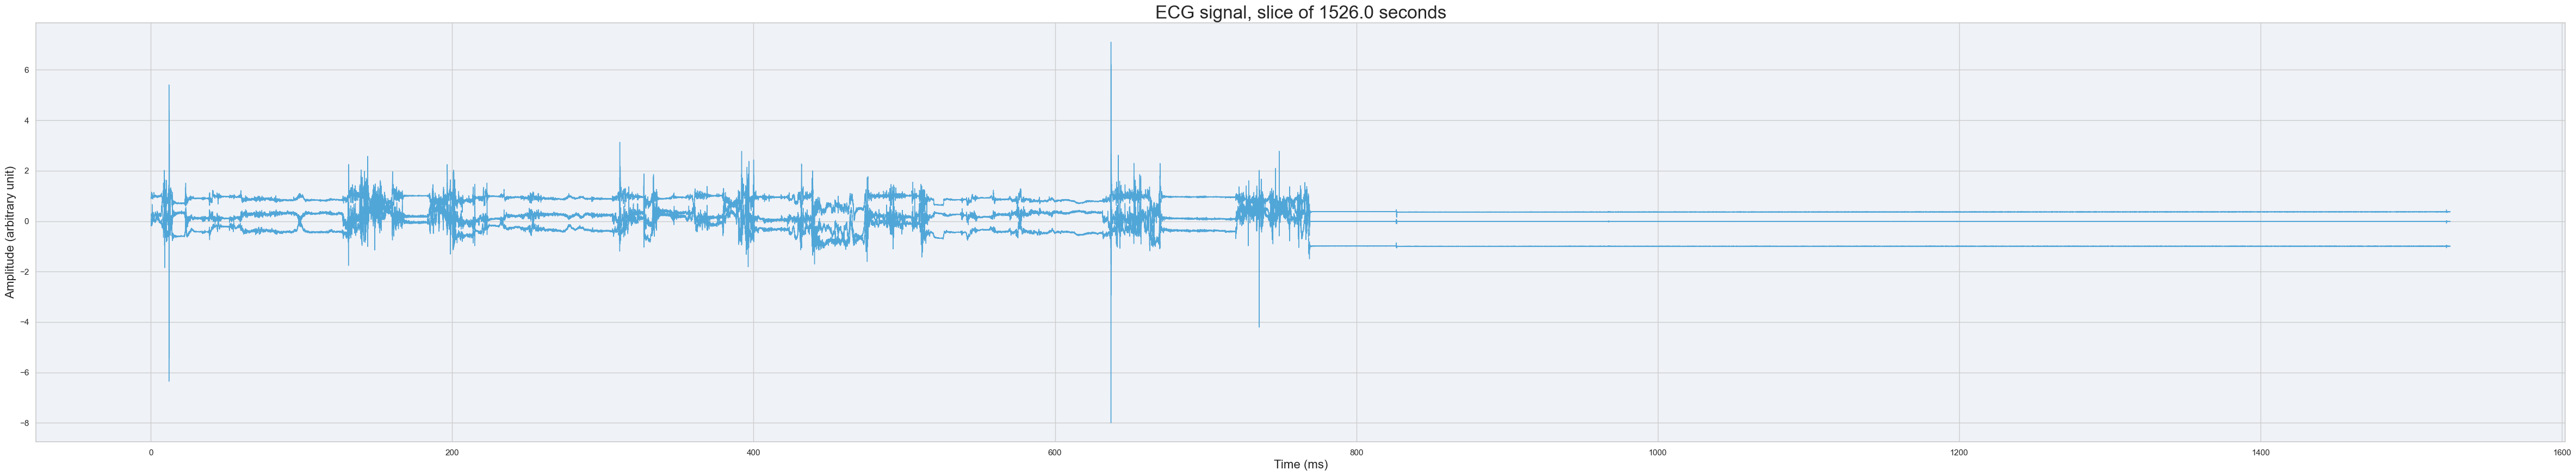

In [9]:
# trim = 1250
# trim = 12000
trim = -1
DoP_ID = 0

dev_id = 0
channel = 0
# dev_id = 10
# channel = 12

def get_data_from_json(DoP_ID, dev_id, channel, show_graph=True):
    data = get_json_data(json_files_list[DoP_ID])
    
    total_duration = data[-1]['time'] 
    print(total_duration / 60)
    
    # Extract addresses and find unique instances
    addresses = [item.get('address') for item in data if item.get('address')]
    
    # prompt: initiate dictionary from unique_addresses with 2 dimentional arrays as velues
    unique_addresses = set(addresses)
    
    device_data = {address: [] for address in unique_addresses}
    data_timeline = {address: [] for address in unique_addresses}
    
    for item in data:
      address = item.get('address')
      id = re.search(r"/(\d+)/", address).group(1)
      data_timeline[address].append([item['time'], item['args']])
    
    for address in unique_addresses:
        times = [entry[0] for entry in data_timeline[address]]
        args = [entry[1] for entry in data_timeline[address]]
        device_data[address] = [times, args]
    
    device_data = np.asarray(device_data["/%s/raw" % dev_id], dtype="object")
    print(device_data.shape)
    # Assuming graph contains [time, args]
    times = device_data[0]  # First part (e.g., time)
    if (channel == 0):
        sensors = [[entry[0][channel], entry[0][channel+1], entry[0][channel+2]] for entry in device_data[1]]  # Assuming entry[1] is the args part
    else:
        sensors = [entry[0][channel] for entry in device_data[1]]  # Assuming entry[1] is the args part
    sensors_graph = sensors[:trim]
    times_graph = times[:trim]
    
    plt.figure(figsize=(60, 10))
    # start = 0
    # stop = 5000
    # duration = (stop-start) / settings['fs']
    duration = times[trim]
    if show_graph:
        plt.title("ECG signal, slice of %.1f seconds" % duration, fontsize=24)
        plt.plot(times_graph, sensors_graph, color="#51A6D8", linewidth=1)
        plt.xlabel("Time (ms)", fontsize=16)
        plt.ylabel("Amplitude (arbitrary unit)", fontsize=16)
    return times, sensors, duration

for jf_id, jf in enumerate(json_files_list[:-4]):
    if "Resting" not in jf:
        # print (jf)
        times, sensors, duration = get_data_from_json(jf_id, dev_id, channel)

## Find RR-intervals

### Peak detection using template matching & threshold

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


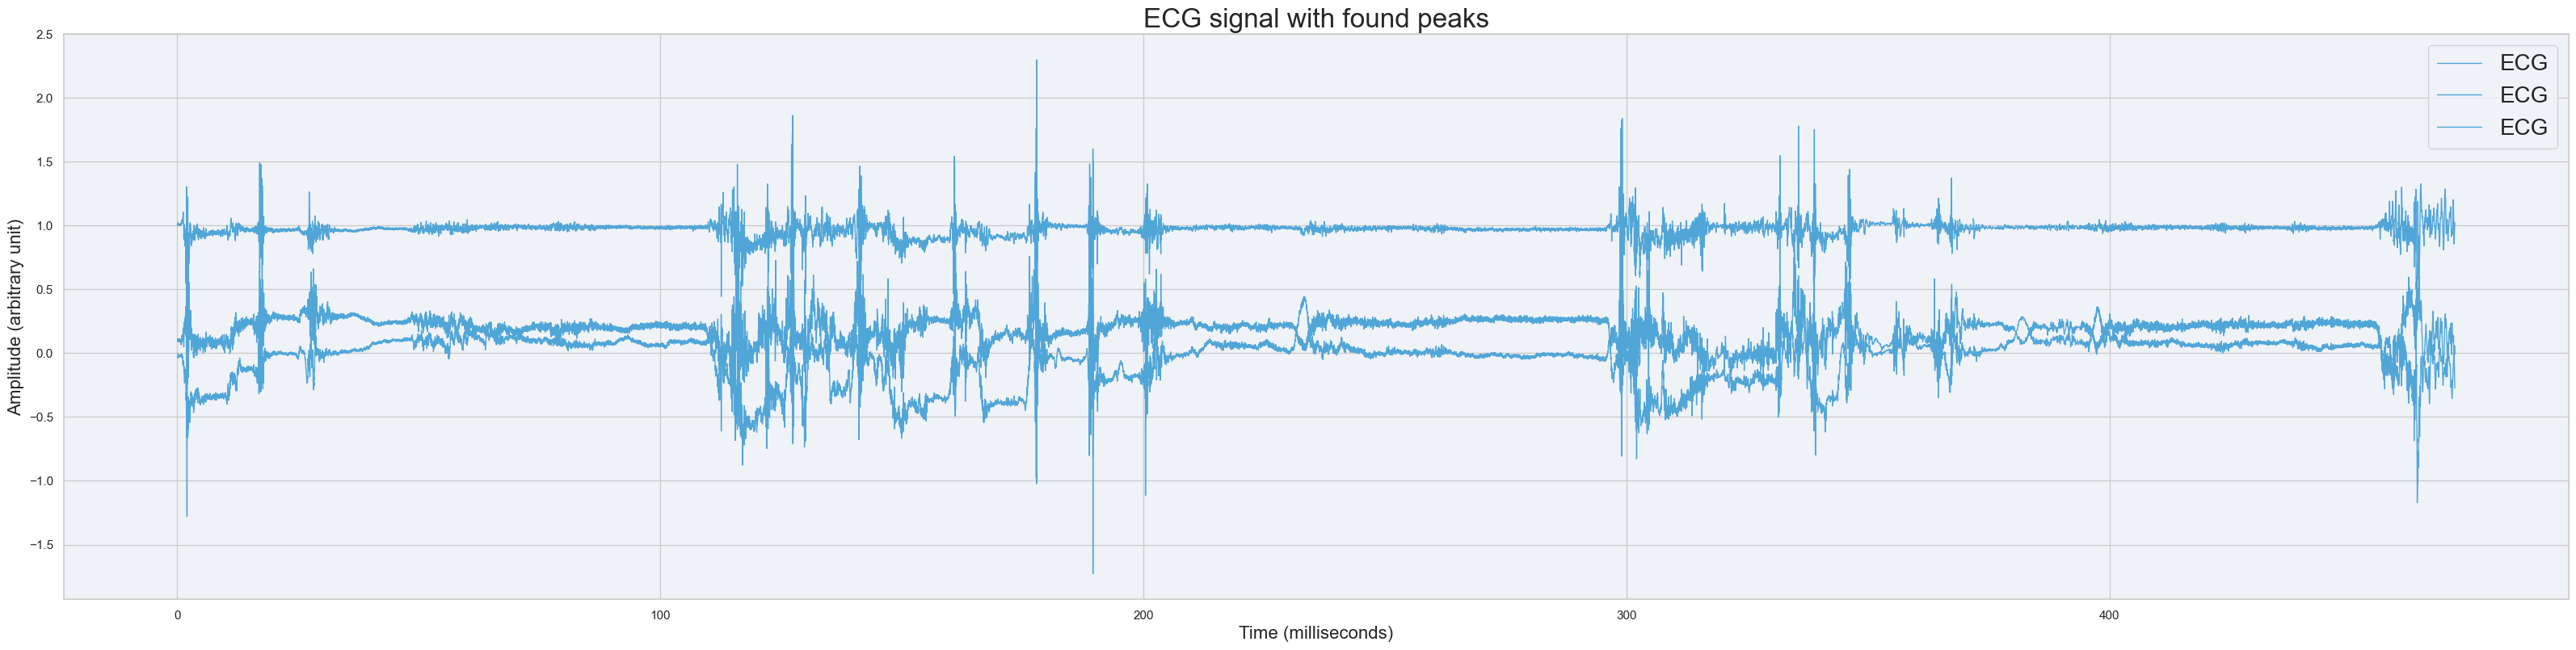

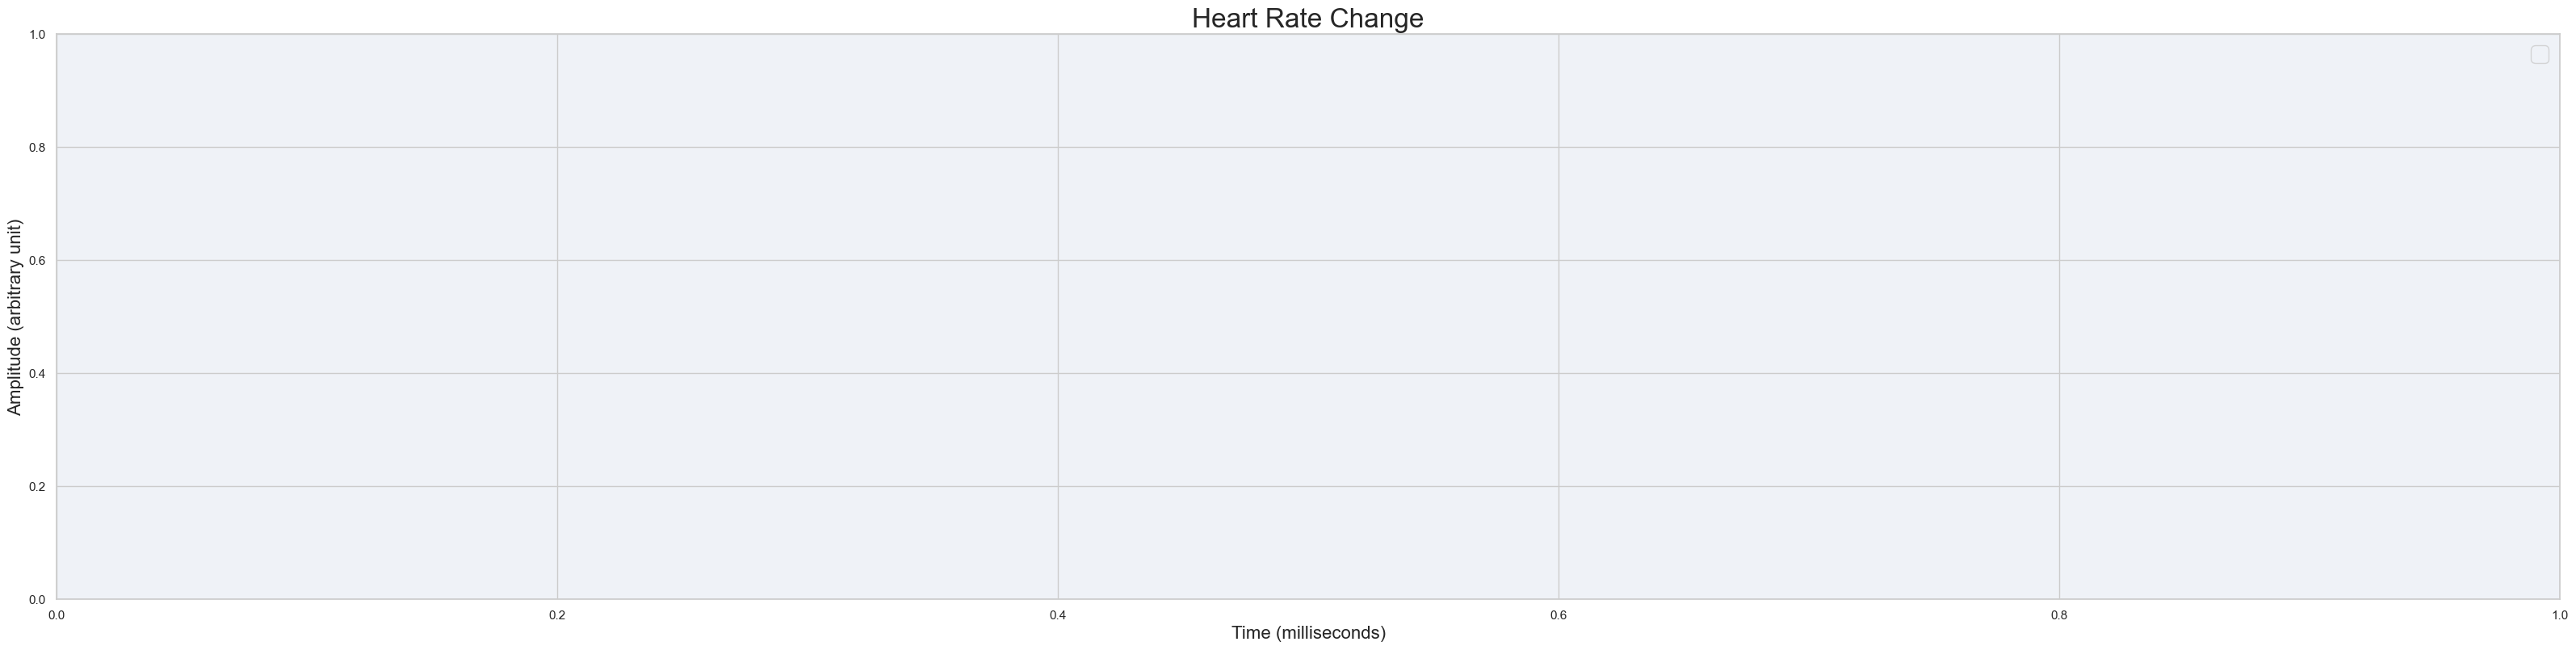

In [111]:
sampfrom = 0
sampto = len(times) - 1
#sampto = 10000
nr_plots = 1

df = pd.DataFrame({"index": times, "heartrate": sensors})

# n = 250 # Step size for the difference
# test_data = times[:]
# diff = np.diff(times[::n])
# print("Difference between elements spaced by", n, "indices:", diff)

for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
    # get slice data of ECG data
    cond_slice = (df.index >= start) & (df.index < stop)
    if (channel != 0):
        ecg_slice = df.heartrate[cond_slice]
    else:
        x_slice = df.heartrate[cond_slice]
        ecg_slice = [[acc[0],acc[1],acc[2]] for acc in df.heartrate[cond_slice]]
    # detect peaks
    # peaks, similarity = detect_peaks(ecg_slice, threshold=0.1)
    # normalised_ecg = (ecg_slice - ecg_slice.mean()) / ecg_slice.std()
    if (len(ecg_slice) > 1125):
        #ecg_stats = ecg.ecg(signal=ecg_slice, sampling_rate=1000/4, show=0)
        ecg_stats = acc.acc(signal=ecg_slice, sampling_rate=1000/10, show=0)
        peaks = ecg_stats[2]
        ecg_slice_filtered = ecg_stats[1]
    else:
        break

    # duration = times[stop] - times[start]
    # sample_freq = (stop-start)/duration
    # print("samples per second: ", sample_freq)
    # print("seconds: ", sample_freq * times[stop])
    # print("seconds: ", duration)

    #acc_slice_filtered = [list(row) for row in zip(*ecg_slice_filtered)]
    acc_slice_filtered = np.array(ecg_slice_filtered).T
    # plot similarity
    plt.figure(figsize=(40, 20))

    plt.subplot(211)
    plt.title("ECG signal with found peaks", fontsize=24)
    # plt.plot(ecg_slice.index - start, ecg_slice_filtered, label="ECG", color="#51A6D8", linewidth=1)
    #plt.plot(times[ecg_slice.index - start], ecg_slice_filtered, label="ECG", color="#51A6D8", linewidth=1)
    for i, line in enumerate(acc_slice_filtered):
        plt.plot(times[x_slice.index - start], line, label="ECG", color="#51A6D8", linewidth=1)
    if (channel != 0):
        plt.plot(times[peaks], ecg_slice_filtered[peaks], markersize=10, label="peaks", color="orange", marker="o", linestyle="None")
    plt.legend(loc="upper right", fontsize=20)
    plt.xlabel("Time (milliseconds)", fontsize=16)
    plt.ylabel("Amplitude (arbitrary unit)", fontsize=16)

    # plot similarity
    plt.figure(figsize=(40, 20))
 
    plt.subplot(212)
    plt.title("Heart Rate Change", fontsize=24)
    # plt.plot(ecg_slice.index, ecg_slice, label="ECG", color="#51A6D8", linewidth=1)
    # plt.plot(peaks, np.repeat(3000, peaks.shape[0]), markersize=10, label="peaks", color="orange", marker="o", linestyle="None")
    if (channel != 0):
        plt.plot(ecg_stats[5], ecg_stats[6], label="Heart Rate", color="#51A6D8", linewidth=1)
    
    plt.legend(loc="upper right", fontsize=20)
    plt.xlabel("Time (milliseconds)", fontsize=16)
    plt.ylabel("Amplitude (arbitrary unit)", fontsize=16)
    
    # plt.savefig(os.path.join(output_path, "peaks-%s-%s.png" % (start, stop)))

### Group similar peaks

### RR intervals: difference between successive peaks

In [9]:
# def group_peaks(p, threshold=5):
#     '''
#     The peak detection algorithm finds multiple peaks for each QRS complex. 
#     Here we group collections of peaks that are very near (within threshold) and we take the median index 
#     '''
#     # initialize output
#     output = np.empty(0)

#     # label groups of sample that belong to the same peak
#     peak_groups, num_groups = label(np.diff(p) < threshold)
#     # print(np.diff(p))
#     # print(peak_groups, num_groups)

#     # iterate through groups and take the mean as peak index
#     for i in np.unique(peak_groups)[1:]:
#         peak_group = p[np.where(peak_groups == i)]
#         output = np.append(output, np.median(peak_group))
#     return output

# normalised_ecg = (df.heartrate - df.heartrate.mean()) / df.heartrate.std()
# # detect peaks
# # peaks, similarity = detect_peaks(df.heartrate, threshold=0.3)
# ecg_stats = ecg.ecg(signal=normalised_ecg, sampling_rate=1000/4, show=0)
# peaks = ecg_stats[2]

# # group peaks
# grouped_peaks = group_peaks(peaks, threshold=125)
# print(grouped_peaks)

# # plot peaks
# plt.figure(figsize=(40, 10))
# plt.title("Group similar peaks together", fontsize=24)
# plt.plot(df.index, normalised_ecg, label="ECG", color="#51A6D8", linewidth=2)
# plt.plot(peaks, np.repeat(0, peaks.shape[0]), markersize=10, label="peaks", color="orange", marker="o", linestyle="None")
# plt.plot(grouped_peaks, np.repeat(10, grouped_peaks.shape[0]), markersize=12, label="grouped peaks", color="k", marker="v", linestyle="None")
# plt.legend(loc="upper right", fontsize=20)
# plt.xlabel("Time (ms)", fontsize=16)
# plt.ylabel("Amplitude (arbitrary unit)", fontsize=16)
# plt.gca().set_xlim(0, 200)

# # detect peaks
# normalised_ecg = (df.heartrate - df.heartrate.mean()) / df.heartrate.std()
# # detect peaks
# # peaks, similarity = detect_peaks(df.heartrate, threshold=0.3)
# ecg_stats = ecg.ecg(signal=normalised_ecg, sampling_rate=1000/4, show=0)
# peaks = ecg_stats[2]

# # group peaks
# grouped_peaks = group_peaks(peaks, threshold=125)

# # RR-intervals are the differences between successive peaks
# rr = np.diff(grouped_peaks)
# print(rr)

# # plot RR-intervals
# plt.figure(figsize=(40, 15))
# plt.title("RR-intervals", fontsize=24)
# plt.xlabel("Time (ms)", fontsize=16)
# plt.ylabel("RR-interval (ms)", fontsize=16)

# plt.plot(np.cumsum(rr), rr, label="RR-interval", color="#A651D8", linewidth=2)

# plt.figure(figsize=(40, 10))
# plt.title("Distribution of RR-intervals", fontsize=24)
# sns.kdeplot(rr, label="rr-intervals", color="#A651D8", fill=True)

# outlier_low = np.mean(rr)-2 * np.std(rr)
# outlier_high = np.mean(rr)+2 * np.std(rr)

# plt.axvline(x=outlier_low)
# plt.axvline(x=outlier_high, label="outlier boundary")
# plt.text(outlier_low - 270, 0.004, "outliers low (< mean - 2 sigma)", fontsize=20)
# plt.text(outlier_high + 20, 0.004, "outliers high (> mean + 2 sigma)", fontsize=20)

# plt.xlabel("RR-interval (ms)", fontsize=16)
# plt.ylabel("Density", fontsize=16)

# plt.legend(fontsize=24)

# plt.figure(figsize=(40, 15))

# rr_corrected = rr.copy()
# rr_corrected[np.abs(zscore(rr)) > 2] = np.median(rr)

# plt.title("RR-intervals", fontsize=24)
# plt.xlabel("Time (ms)", fontsize=16)
# plt.ylabel("RR-interval (ms)", fontsize=16)

# plt.plot(rr, color="red", linewidth=1, label="RR-intervals")
# plt.plot(rr_corrected, color="green", linewidth=2, label="RR-intervals after correction")
# plt.legend(fontsize=20)

### Plot ECG vs RR intervals

In [10]:
# sampfrom = 0
# sampto = 10000
# nr_plots = 1

# # detect peaks
# # peaks, similarity = detect_peaks(df.heartrate, threshold=0.3)
# normalised_ecg = (ecg_slice - ecg_slice.mean()) / ecg_slice.std()
# ecg_stats = ecg.ecg(signal=ecg_slice, sampling_rate=1000/4, show=0)
# peaks = ecg_stats[2]
# ecg_slice_filtered = ecg_stats[1]

# # RR-intervals are the differences between successive peaks
# rr = np.diff(peaks)
# rr_ms = rr / 250
# # print(np.cumsum(rr)+peaks[0])

# for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
#     # plot similarity
#     plt.figure(figsize=(40, 10))

#     plt.title("ECG signal & RR-intervals", fontsize=24)
#     # plt.plot(df.index, ecg_slice_filtered, label="ECG", color="#51A6D8", linewidth=1)
#     plt.plot(ecg_slice.index - start, ecg_slice_filtered, label="ECG", color="#51A6D8", linewidth=1)
#     plt.plot(peaks, ecg_slice_filtered[peaks], markersize=10, label="peaks", color="orange", marker="o", linestyle="None")
#     plt.legend(loc="upper left", fontsize=20)
#     plt.xlabel("Time (milliseconds)", fontsize=16)
#     plt.ylabel("Amplitude (arbitrary unit)", fontsize=16)
#     plt.gca().set_ylim(-1000, 2000)
#     # ax2 = plt.gca().twinx()
#     ax2 = plt.subplot().twinx()
#     ax2.plot(np.cumsum(rr)+peaks[0], rr_ms, label="RR-intervals", color="#A651D8", linewidth=2, markerfacecolor="#A651D8", markeredgewidth=0, marker="o", markersize=8)
#     ax2.set_xlim(start, stop)
#     ax2.set_ylim(-0.2, 0.9)
#     ax2.legend(loc="upper right", fontsize=20)

#     plt.xlabel("Time (ms)", fontsize=16)
#     plt.ylabel("RR-interval (ms)", fontsize=16)

#     # plt.savefig(os.path.join(output_path, "ecg-with-rr-%s-%s.png" % (start, stop)))

### Plot ECG vs RR intervals

['s1_SHE', 's1_HE', 's2_HE', 's2_SHE', 's3_SHE', 's3_HE', 's4_HE', 's4_SHE', 's5_SHE', 's5_HE', 's6_HE', 's6_SHE']
0 s1_SHE
../Data/Sensors/Day_1/s1/recordings-102224-10_53_51.json
7.858931534716673
(2, 42694)
Progress: 99.55493089716562%%%

<Figure size 6000x1000 with 0 Axes>

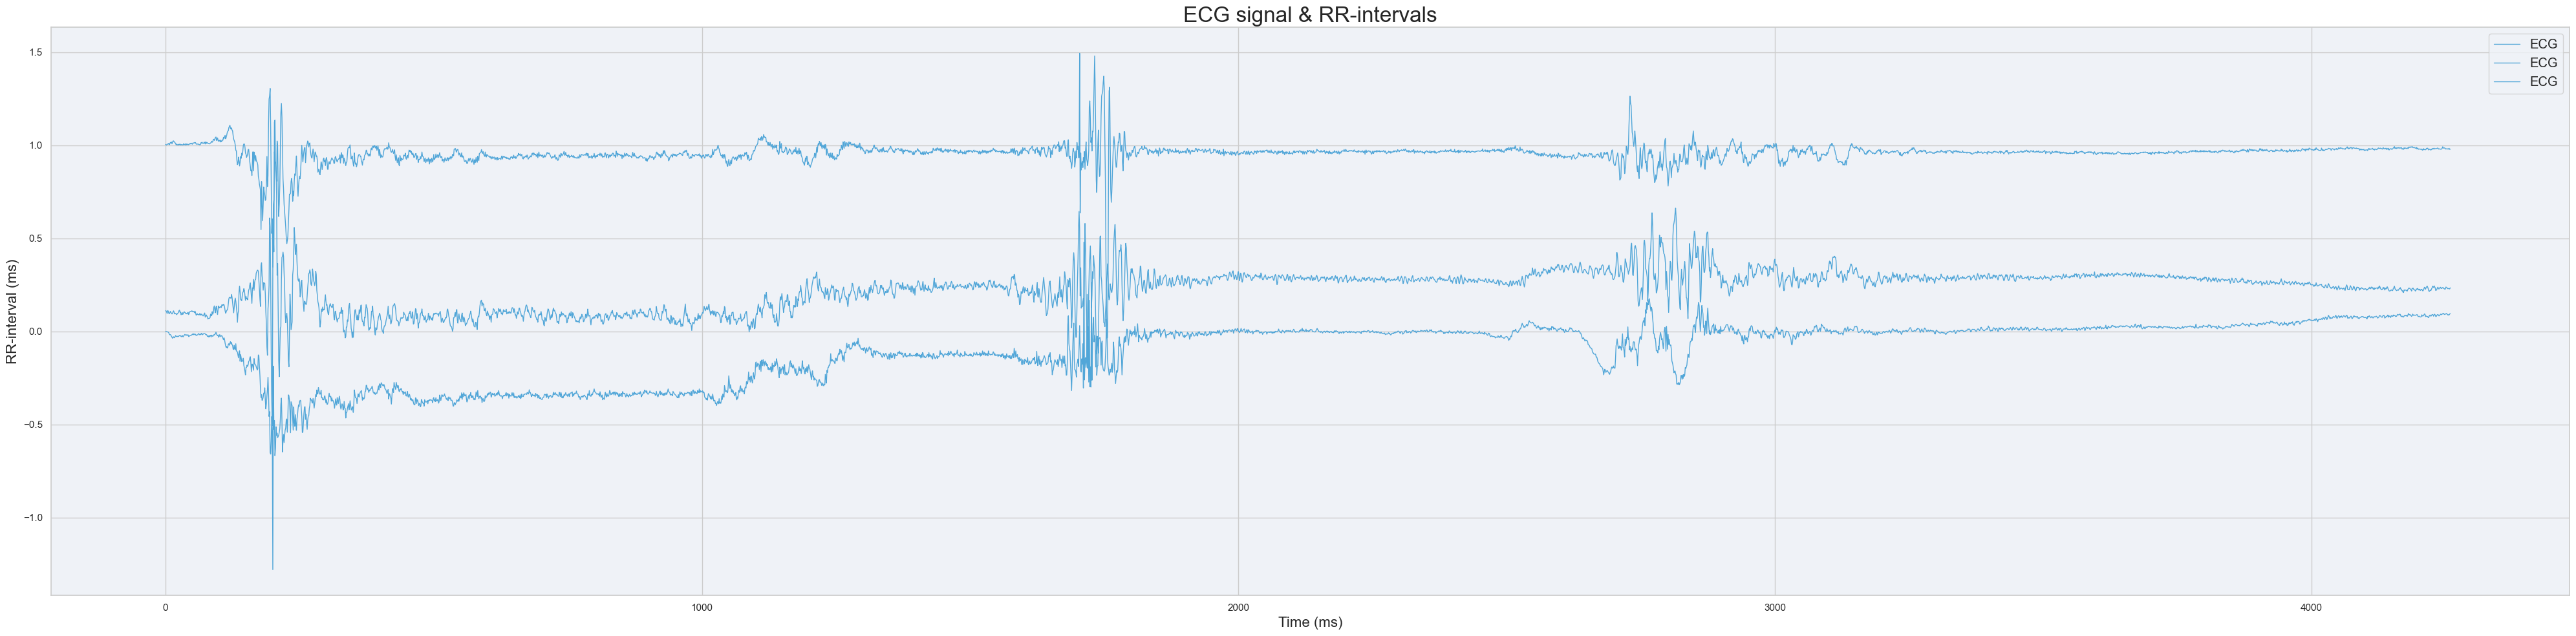

Progress: 99.55493089716562%%%

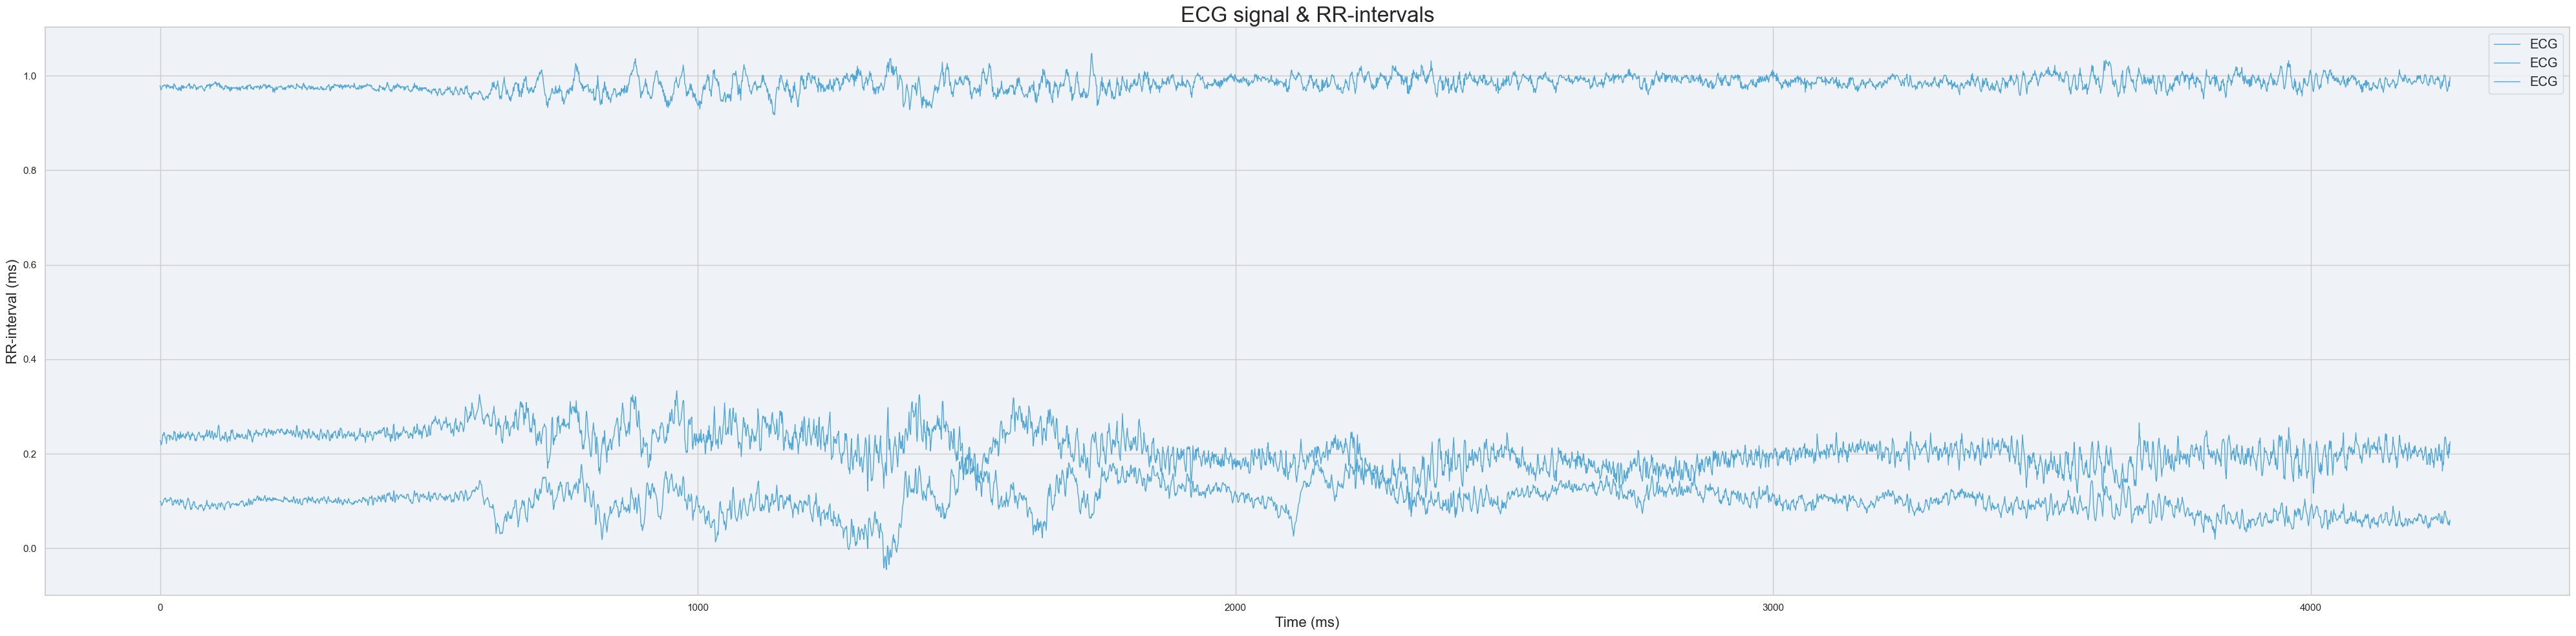

Progress: 99.55493089716562%%%

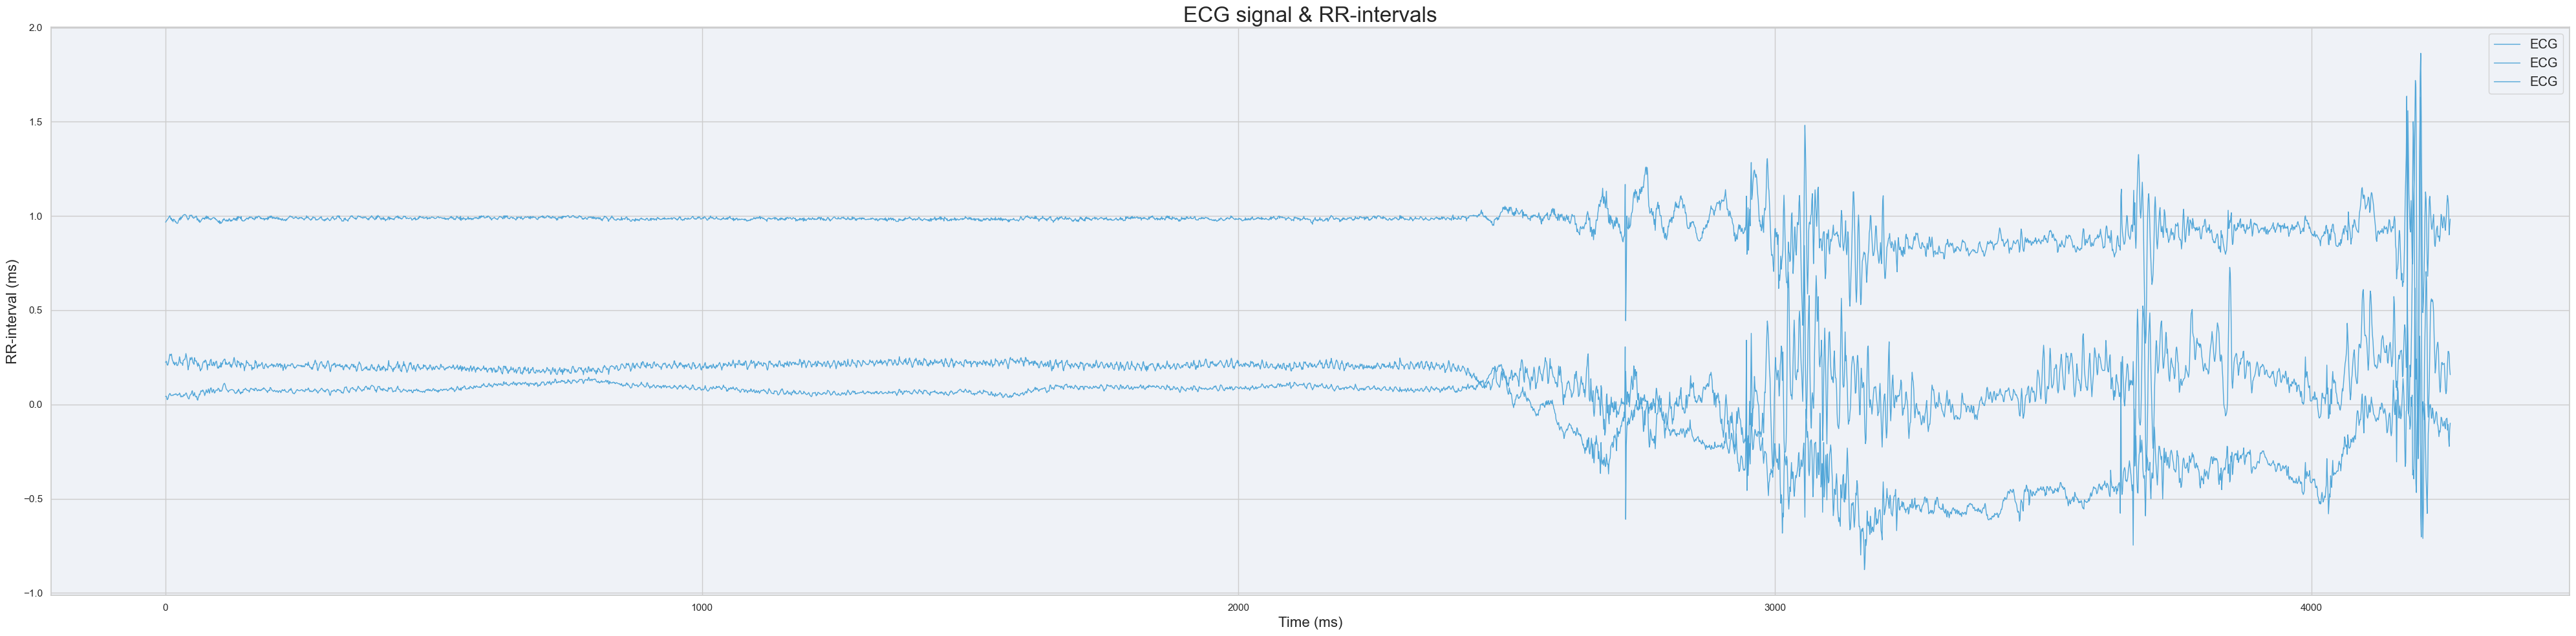

Progress: 99.55493089716562%%%

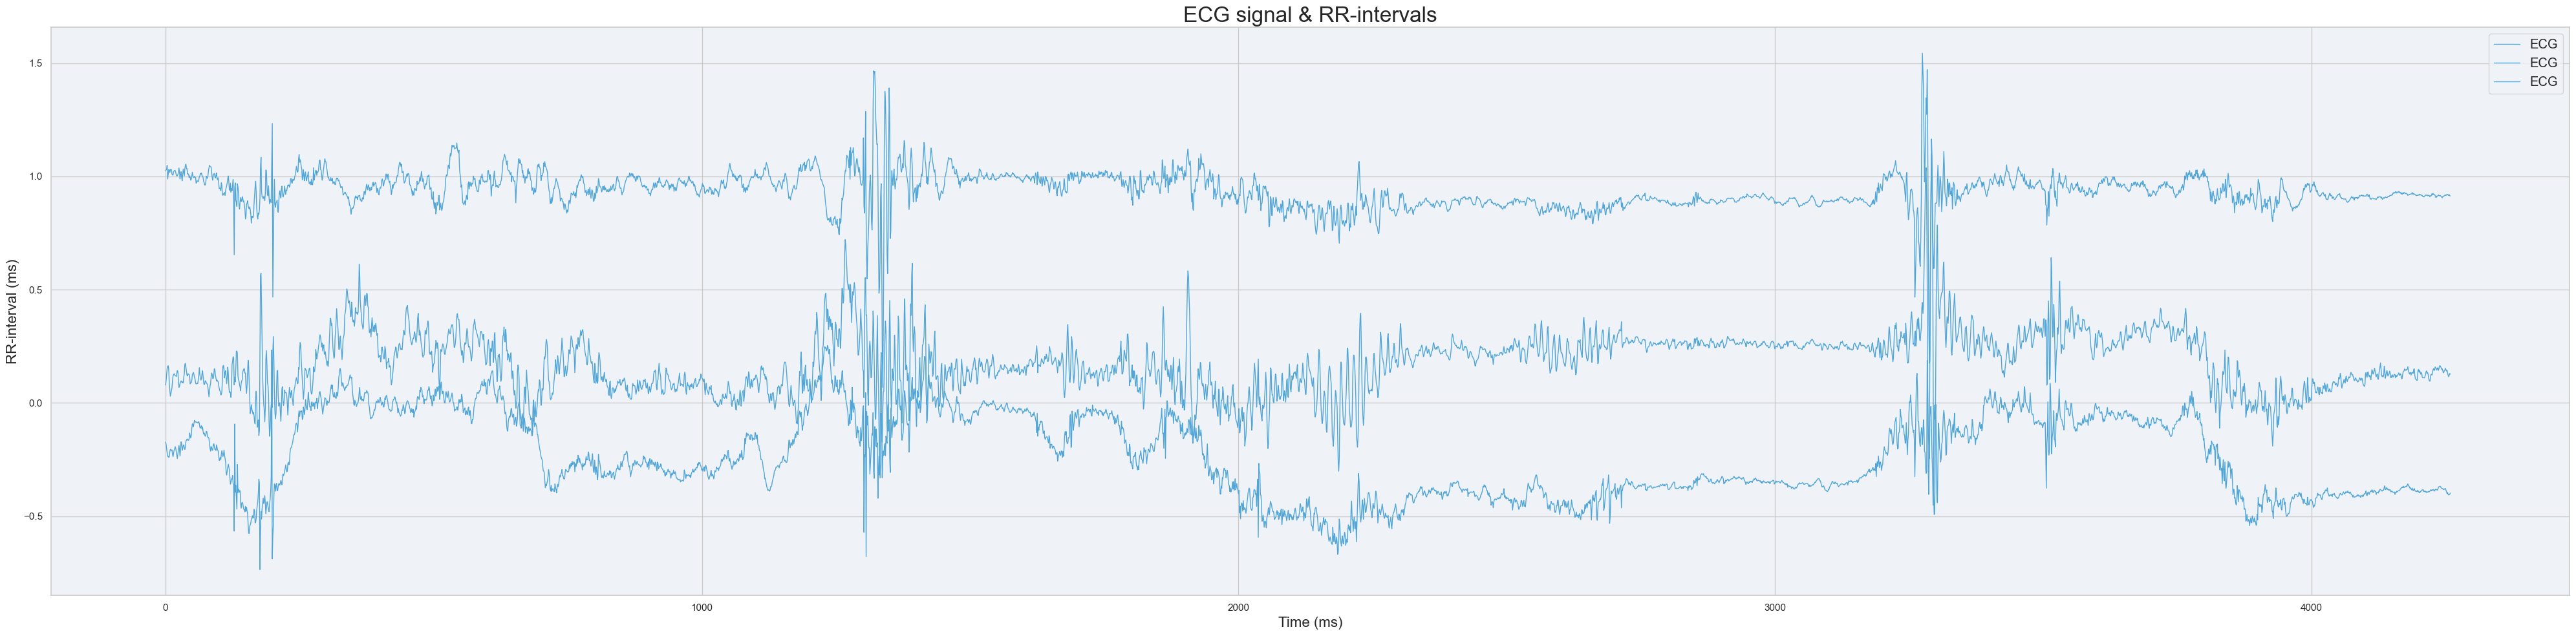

Progress: 99.55493089716562%%%

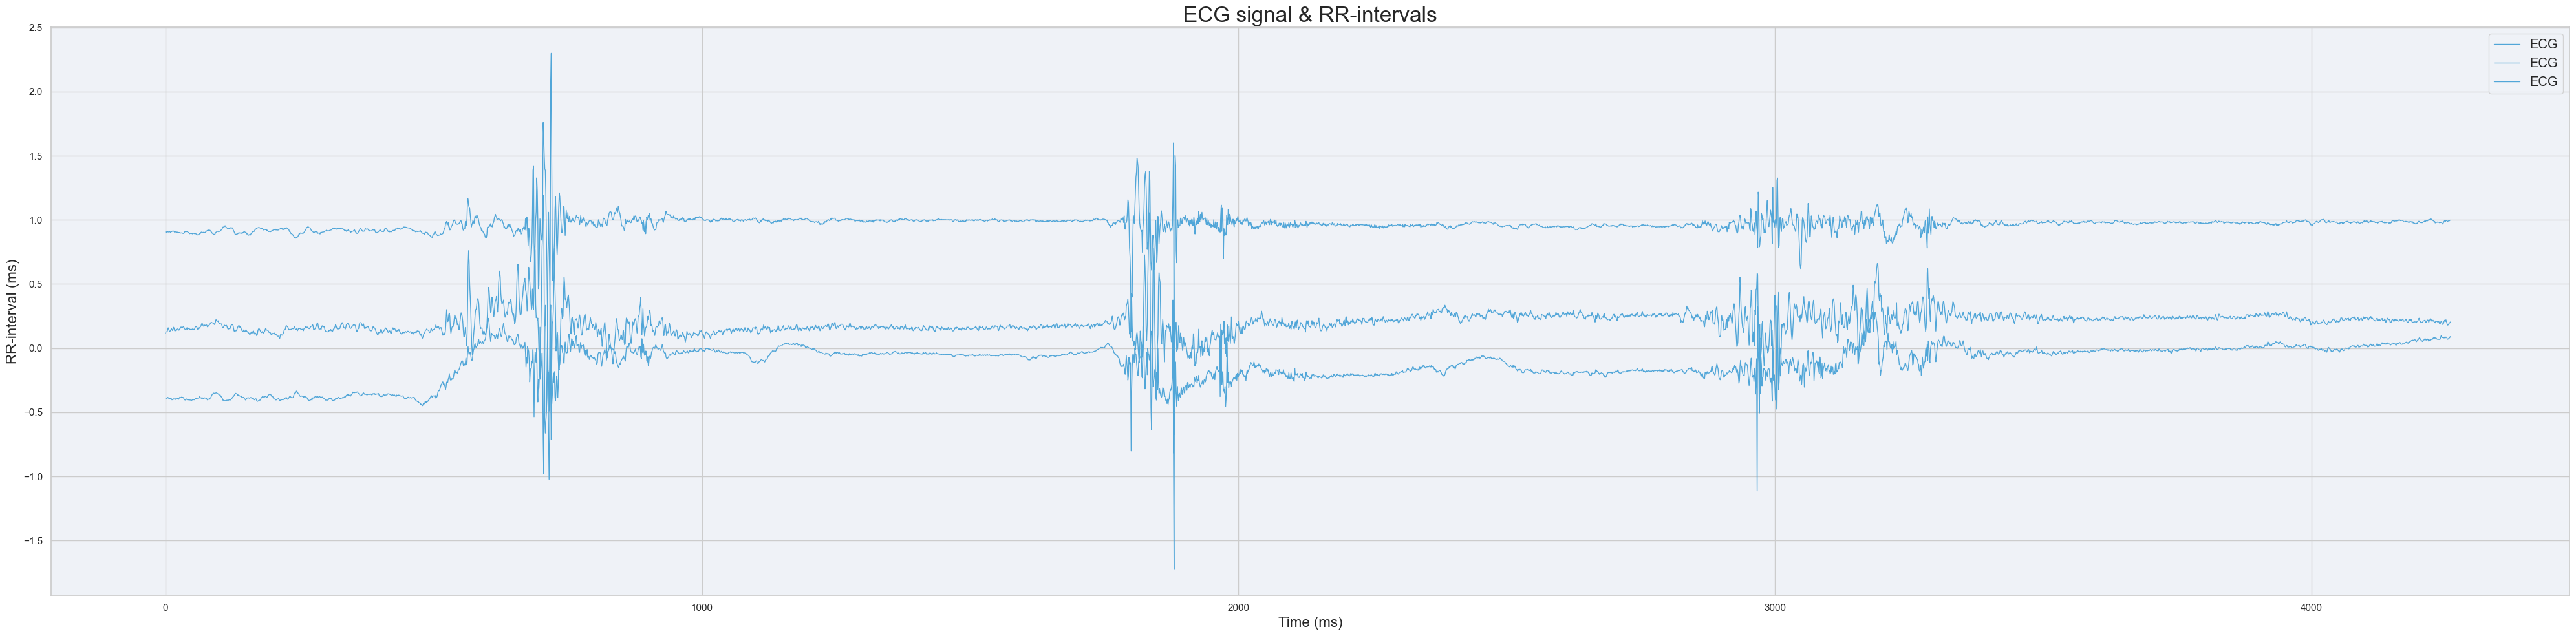

Progress: 99.55493089716562%%%

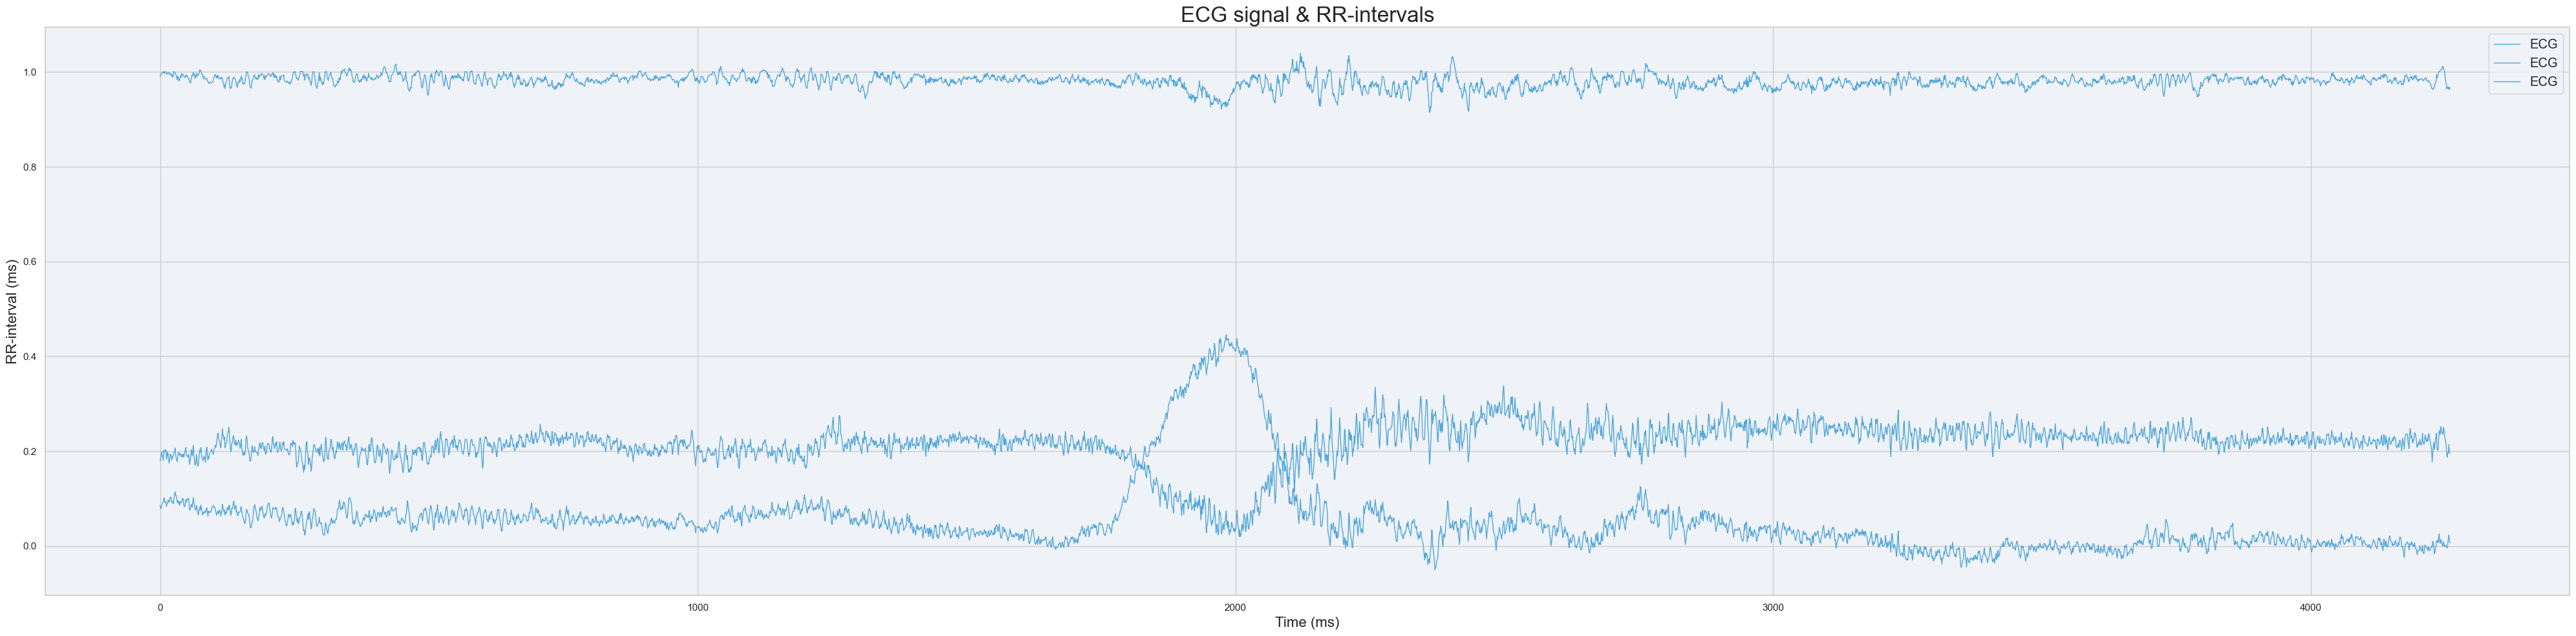

Progress: 99.55493089716562%%%

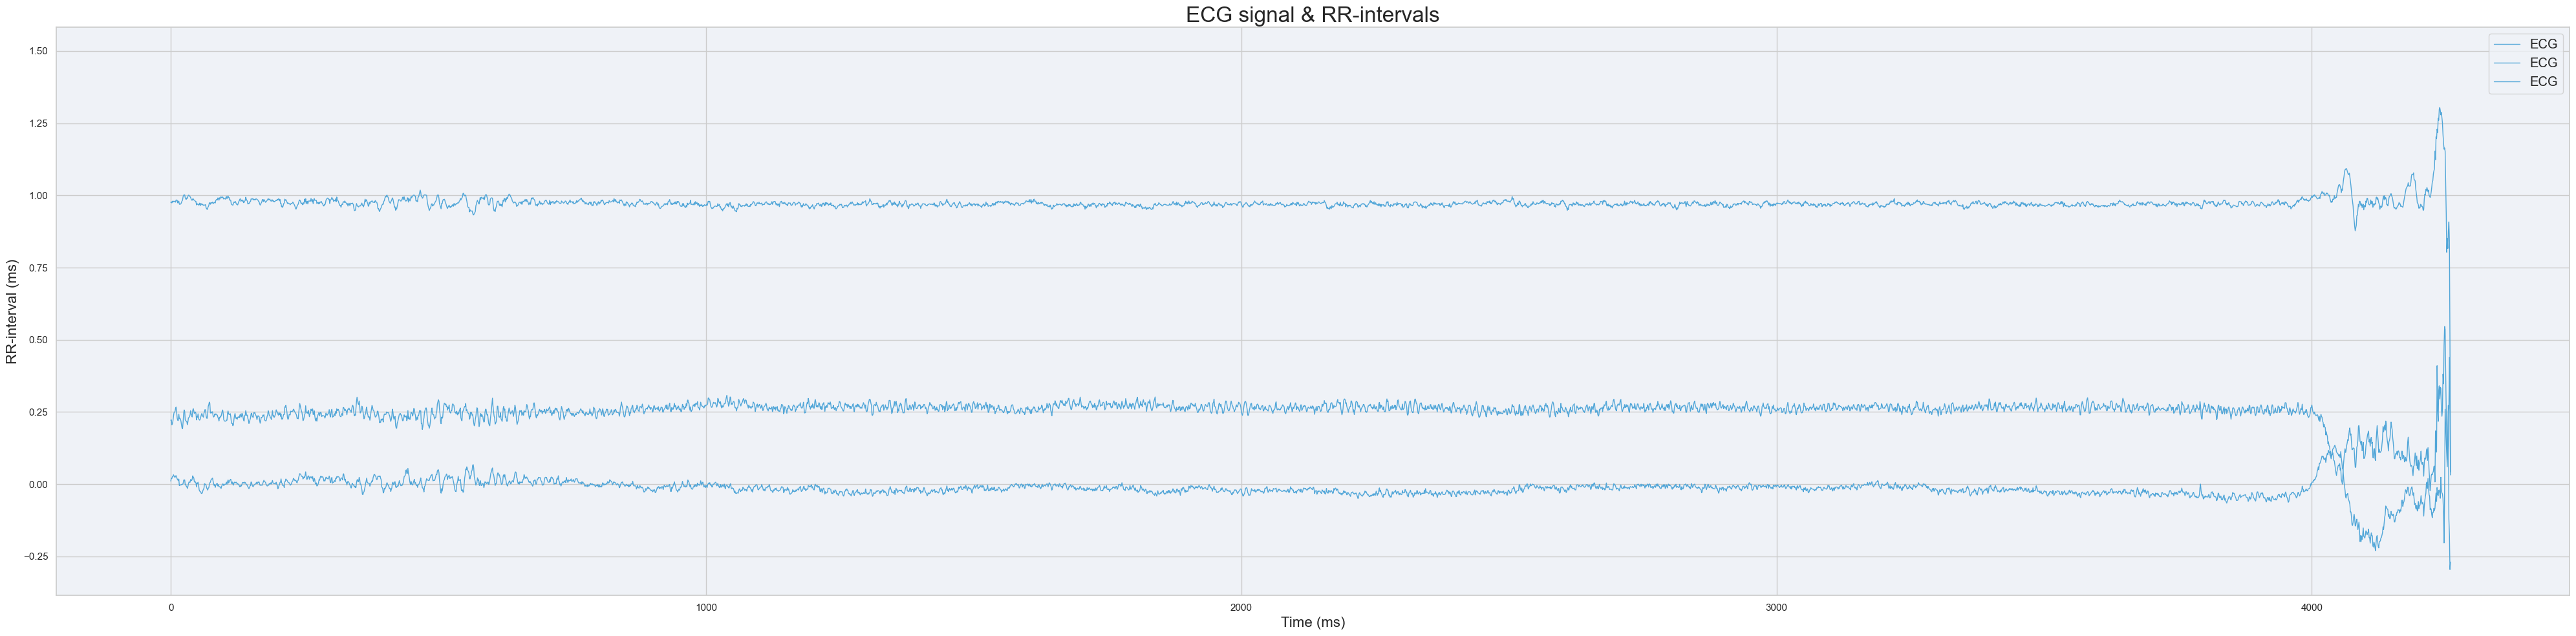

Progress: 99.55493089716562%%%

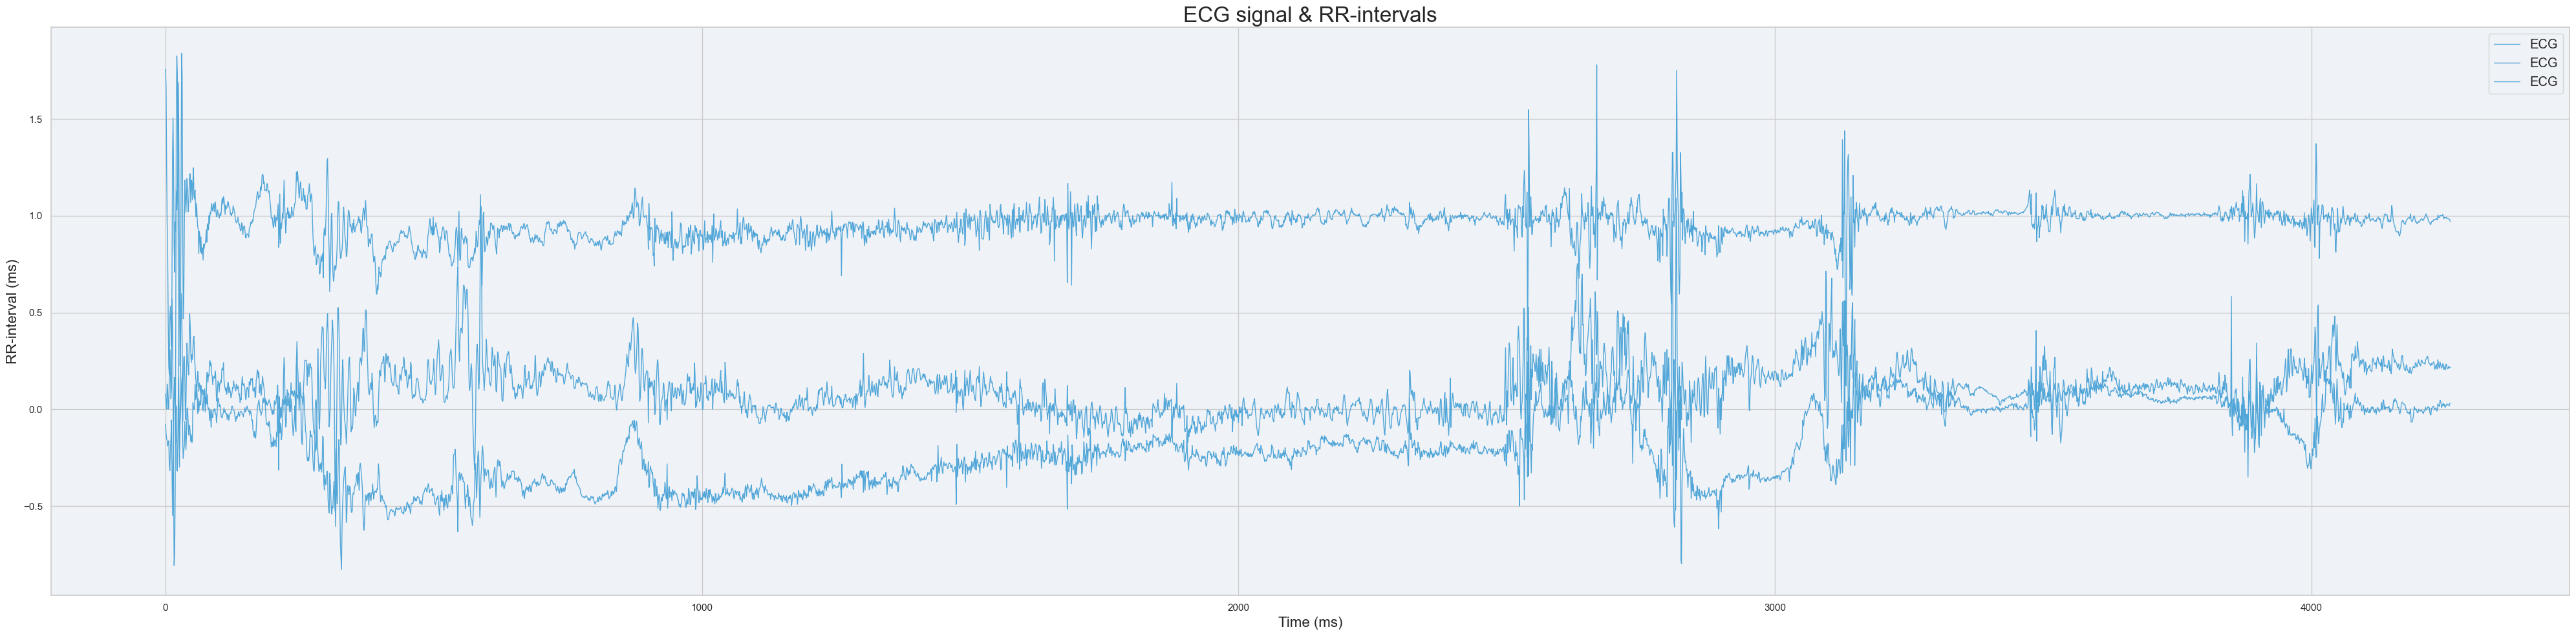

Progress: 99.55493089716562%%%

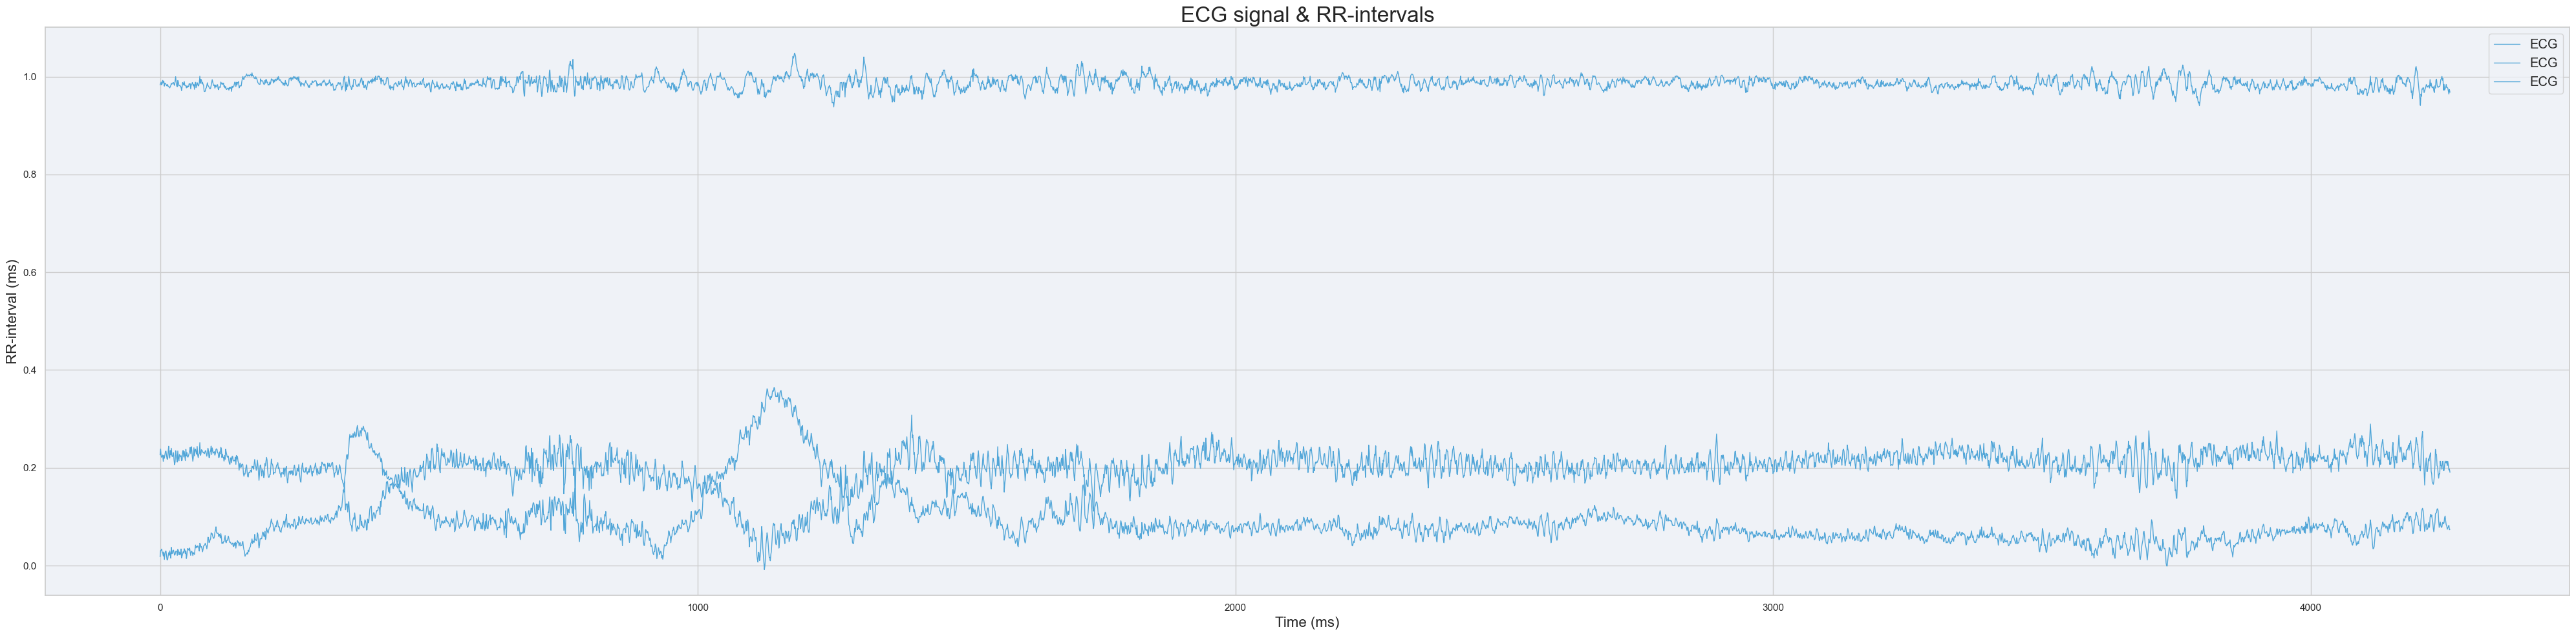

Progress: 99.55493089716562%%%

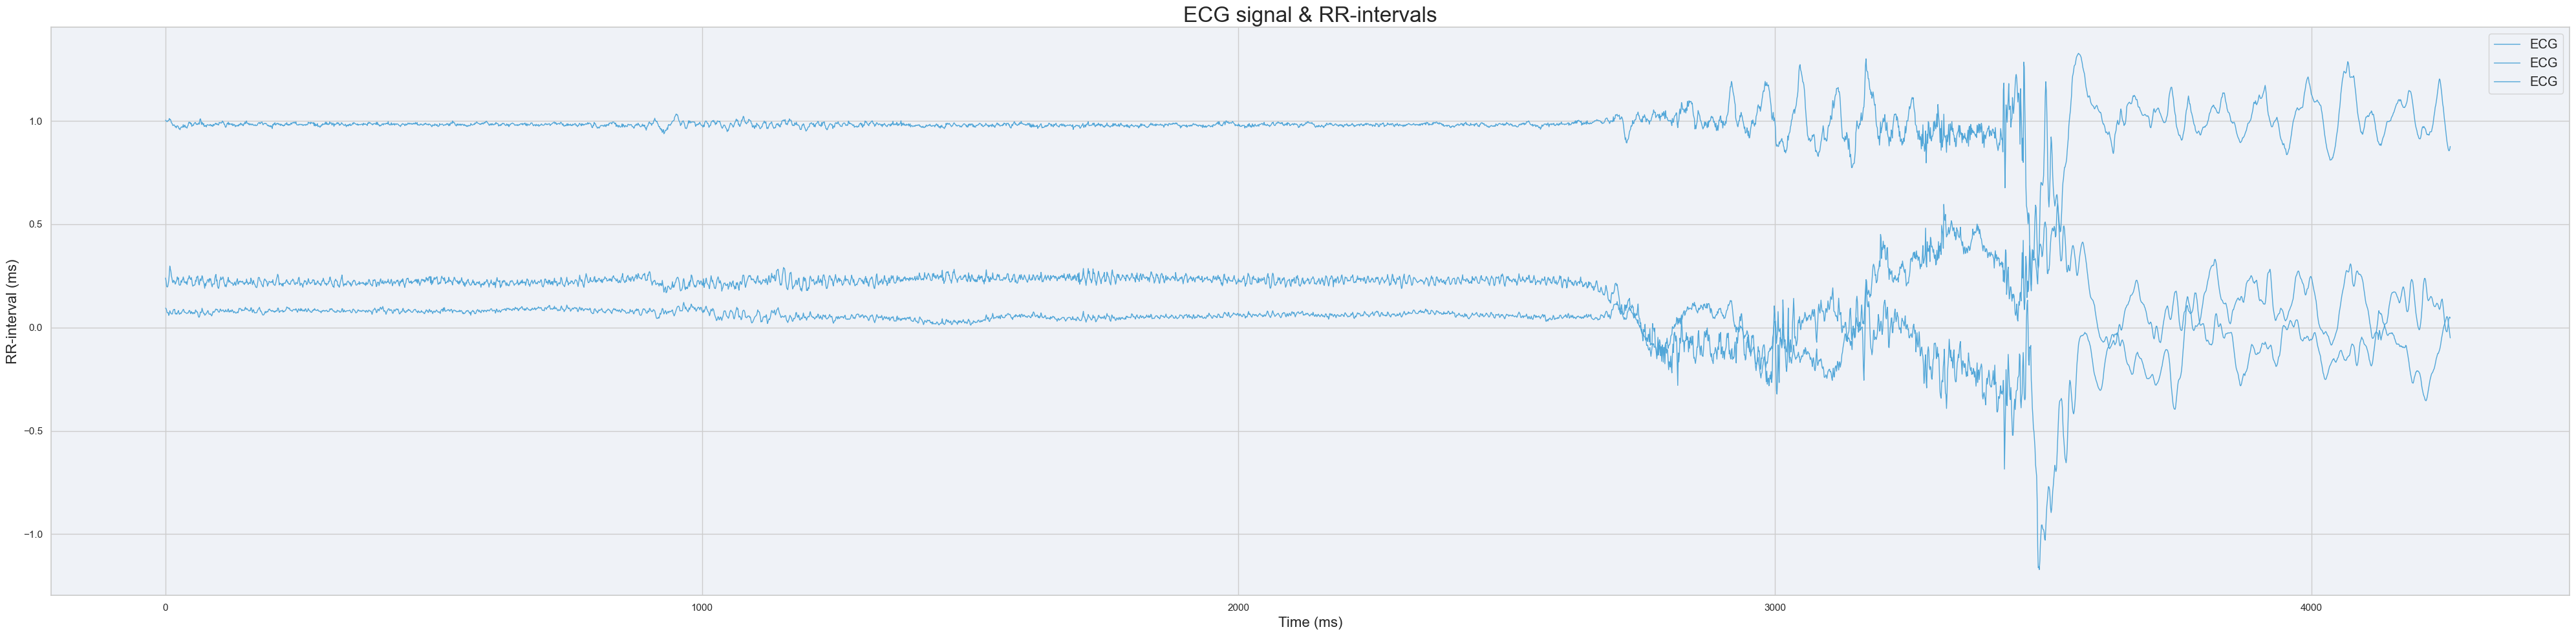

1 s1_HE
../Data/Sensors/Day_1/s1/recordings-102224-11_31_23.json
7.743354950000017
(2, 46444)
Progress: 99.69853574504737%%

<Figure size 6000x1000 with 0 Axes>

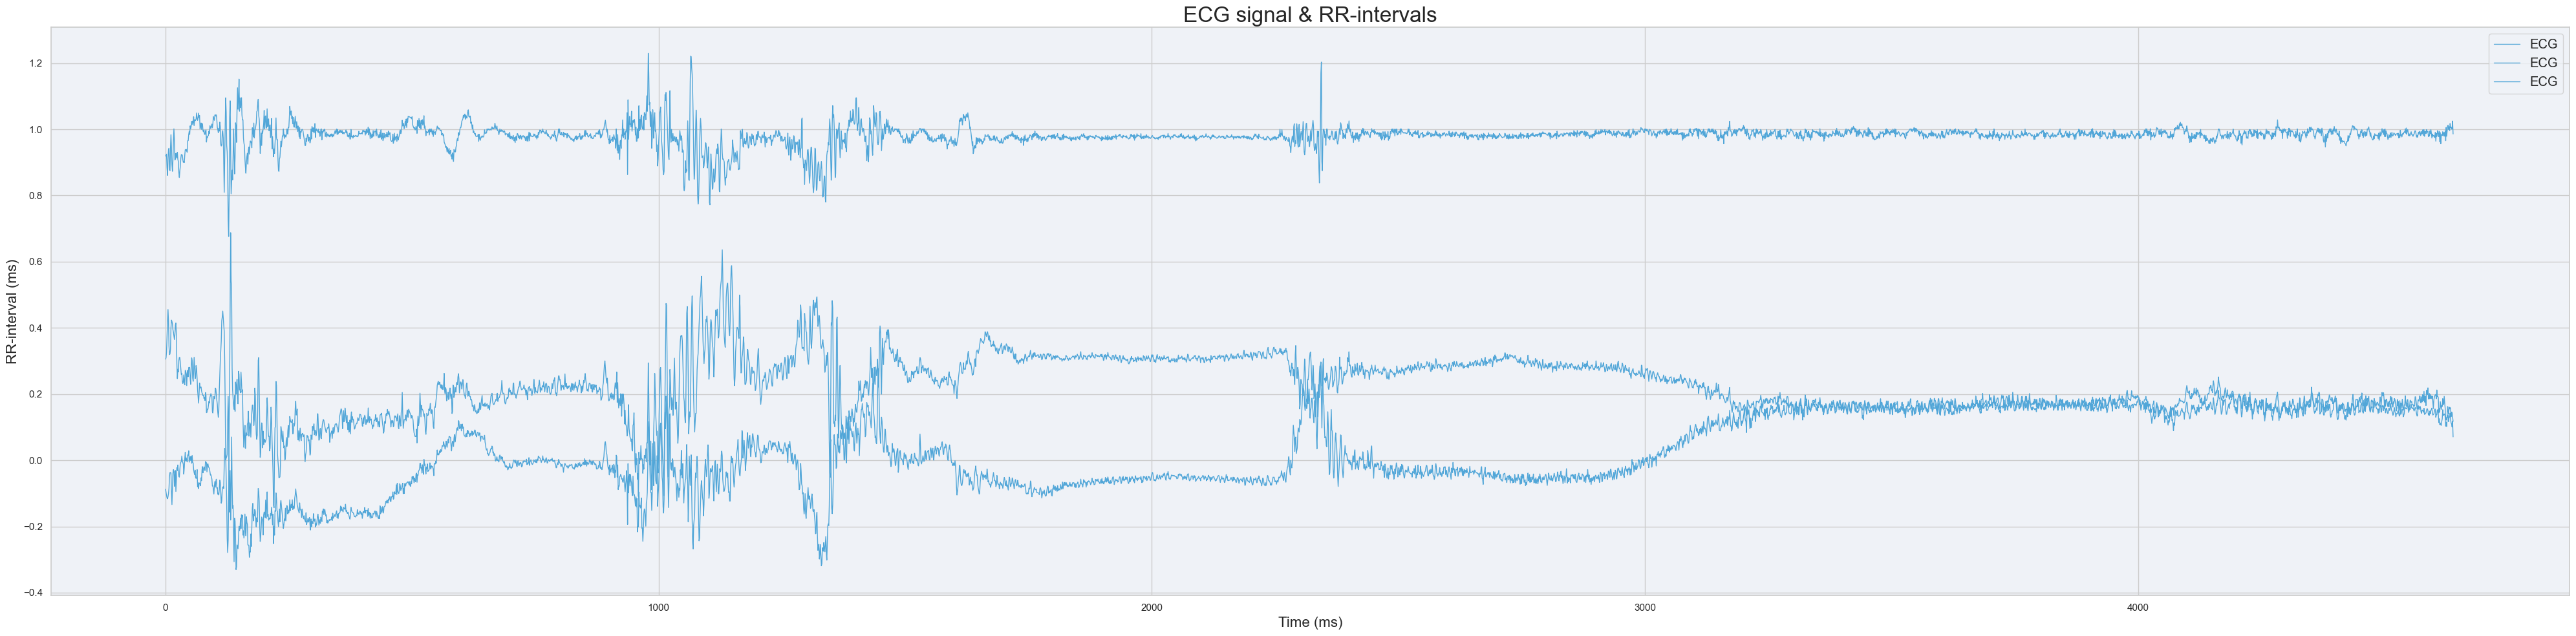

Progress: 74.50473729543498%%

In [ ]:
DoP_ID = 0

def render_sensor_graph(df, times, interval=250):
    sampfrom = 0
    sampto = len(times) - 1
    # sampto = 81260
    nr_plots = 10
    # Batch size for animation
    batch_size = 10
    
    def update_batch(batch_index):
        start = batch_index * batch_size
        end = start + batch_size
        print(f"\rProgress: {(start / num_frames)*100}%", end="")  # Print on the same line
        
        # update the line plot
        #ecg_line.set_xdata(ecg_x[:end])
        #ecg_line.set_ydata(ecg_slice_filtered[:end])
        
        for i, line in enumerate(acc_slice_filtered):
            ecg_line[i].set_xdata(ecg_x[:end])
            ecg_line[i].set_ydata(line[:end])
        if (channel != 0):
            anim_ecg_peaks = peaks[peaks < ecg_x[start]]
            ecg_peaks.set_xdata(anim_ecg_peaks)
            ecg_peaks.set_ydata(ecg_slice_filtered[anim_ecg_peaks])
        
            rr_line.set_xdata(rr_x_interp[:end])
            rr_line.set_ydata(rr_y_interp[:end])
    
            anim_rr_peaks = np.where(peaks[:-1] < ecg_x[start])
            rr_peaks.set_xdata(rr_x[anim_rr_peaks])
            rr_peaks.set_ydata(rr_ms[anim_rr_peaks])
    
        return (ecg_line)
    
    for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
        cond_slice = (df.index >= start) & (df.index < stop) 
        ecg_slice = df.heartrate[cond_slice]

        if (channel != 0):
            ecg_slice = df.heartrate[cond_slice]
        else:
            x_slice = df.heartrate[cond_slice]
            ecg_slice = [[acc[0],acc[1],acc[2]] for acc in df.heartrate[cond_slice]]
        # detect peaks
        # peaks, similarity = detect_peaks(df.heartrate, threshold=0.3)
        # normalised_ecg = (ecg_slice - ecg_slice.mean()) / ecg_slice.std()
        if (len(ecg_slice) > 1125):
            # ecg_stats = ecg.ecg(signal=ecg_slice, sampling_rate=1000/4, show=0)
            # ecg_stats = ppg.ppg(signal=ecg_slice, sampling_rate=1000/10, show=0)
            ecg_stats = acc.acc(signal=ecg_slice, sampling_rate=1000/10, show=0)
            #peaks = ecg_stats[2]()
            ecg_slice_filtered = ecg_stats[1]
        else:
            break
    
        sample_freq = stop/times[stop]
        interval_ms = 10
        # sampled_times = times[cond_slice][::batch_size]
        time_elapsed = np.diff(times[cond_slice][::batch_size]) * 1000
        frames_elapsed = [round(te / (interval_ms*batch_size)) for te in time_elapsed]
        frame_t = []
        for frame, repeat in enumerate(frames_elapsed):
            # print(frame, repeat)
            frame_t.extend([frame] * repeat)
        
        rr = np.diff(peaks)
        rr_ms = (np.diff(peaks) / interval)*3000
        
        #ecg_x = ecg_slice.index - start
        ecg_x = x_slice.index - start
    
        rr_x = np.cumsum(rr)+peaks[0]
        z2 = rr_ms

        if channel != 0:
            cs = CubicSpline(rr_x, rr_ms)               # Create a cubic spline
            rr_x_interp = np.linspace(rr_x.min(), rr_x.max(), len(ecg_slice_filtered))  # Dense x-points
            rr_y_interp = cs(rr_x_interp)
        # plot similarity
        anim_fig = plt.figure(figsize=(40, 10))
        ax = plt.subplot()

        acc_slice_filtered = np.array(ecg_slice_filtered).T
        ecg_line = []
        plt.title("ECG signal & RR-intervals", fontsize=24)
        # plt.legend(loc="upper left", fontsize=20)
        plt.xlabel("Time (milliseconds)", fontsize=16)
        plt.ylabel("Amplitude (arbitrary unit)", fontsize=16)
        for i, line in enumerate(acc_slice_filtered):
            ecg_line.append(ax.plot(ecg_x, line, label="ECG", color="#51A6D8", linewidth=1)[0])
        #ecg_line = ax.plot(ecg_x, ecg_slice_filtered, label="ECG", color="#51A6D8", linewidth=1)[0]
        
        #ecg_peaks = ax.plot(peaks, ecg_slice_filtered[peaks], markersize=10, label="peaks", color="orange", marker="o", linestyle="None")[0]
    
        #rr_line = ax.plot(rr_x_interp, rr_y_interp, label="RRintervals", color="#A651D8", linewidth=2, markerfacecolor="#A651D8")[0]
        #rr_peaks = ax.plot(rr_x, rr_ms, label="rrpeak", color="#A651D8", linewidth=2, markerfacecolor="#A651D8", markeredgewidth=0, marker="o", markersize=8, linestyle="None")[0]
    
        plt.legend(loc="upper right", fontsize="large")
        plt.xlabel("Time (ms)", fontsize=16)
        plt.ylabel("RR-interval (ms)", fontsize=16)
        plt.tight_layout()
    
        num_frames = len(ecg_slice_filtered)
        # num_frames = 10000
        # ani = animation.FuncAnimation(fig=anim_fig, func=update_batch, frames=round(num_frames / batch_size), interval=(1000/sample_freq) * batch_size)
        ani = animation.FuncAnimation(fig=anim_fig, func=update_batch, frames=frame_t, interval=interval_ms * batch_size)
        ani.save(filename=f"../Output/Sensor_Grpahs/ACC/DP_{identifiers[DoP_ID]}_{start}-{stop}_sync.mp4", writer="ffmpeg")
        plt.show()

print(identifiers)
for jf_id, jf in enumerate(json_files_list[:-4]):
    if "Resting" not in jf:
        print(DoP_ID, identifiers[DoP_ID])
        print(jf)
        # print(f"../Output/Sensor_Grpahs/DP_{identifiers[DoP_ID]}_{start}-{stop}_sync.mp4")
        times, sensors, duration = get_data_from_json(jf_id, dev_id, channel, False)
        df = pd.DataFrame({"index": times, "heartrate": sensors})
        render_sensor_graph(df, times)
        DoP_ID += 1

### Export Concatenated Files

In [ ]:
import subprocess

# Function to optimize MP4 file for the web using FFmpeg
def optimize_mp4(input_video, output_video):
    # command = [
    #     'ffmpeg', 
    #     '-i', input_video, 
    #     '-vcodec', 'libx264', 
    #     '-crf', '23', 
    #     '-preset', 'fast', 
    #     '-acodec', 'aac', 
    #     '-b:a', '128k', 
    #     '-movflags', 'faststart', 
    #     '-vf', 'scale=-1:720',  # Resize to 720p while maintaining aspect ratio
    #     output_video
    # ]
    command = [
        'ffmpeg', 
        '-i', input_video, 
        '-c:v', 'libvpx', 
        '-b:v', '1M', 
        '-c:a', 'libvorbis', 
        '-speed', '4', 
        '-vf', 'scale=640:-1', 
        '-preset', 'ultrafast', 
        output_video
    ]
    subprocess.run(command, stderr=subprocess.DEVNULL)

# output_dir = "../Output/Sensor_Grpahs/"
# concat_dir = "../Output/Sensor_Grpahs/Concatenated/"
# output_dir = "../Output/Sensor_Grpahs/PPG"
# concat_dir = "../Output/Sensor_Grpahs/PPG/Concatenated/"
output_dir = "../Output/Sensor_Grpahs/ACC"
concat_dir = "../Output/Sensor_Grpahs/ACC/Concatenated/"

video_files = []
# Initialize dictionary to store grouped video files by matching substring
grouped_files = {identifier: [] for identifier in identifiers}

for root, _, files in os.walk(output_dir):
    files.sort()
    for file in files:
      if file.endswith(".mp4") and "Concatenated" not in root:
        #print(file)
        video_files.append(os.path.join(root, file))
        matching_substrings = [identifier for identifier in identifiers if identifier in file]
          # Add the file to the corresponding group(s) based on matching substrings
        for match in matching_substrings:
            grouped_files[match].append(os.path.join(root, file))

# Display grouped video files by matching substrings
concatenated_file_paths = []
for substring, files in grouped_files.items():
    if files:  # Only print groups that have matching files
        print(f"Files matching '{substring}':")
        #for file in files:
        #   print(f"  {file}")
        #print('---')
            # Create a temporary file list to pass to FFmpeg
        
        with open("temp_file_list.txt", "w") as f:
            for file in files:
                f.write(f"file '{file}'\n")  # Write each video path on a new line in the temp file

        # Run FFmpeg to concatenate the videos listed in the temp file
        output_filename = f"{concat_dir}{substring}_concatenated.mp4"  # Output file name for the group
        concatenated_file_paths.append(output_filename)
        print(f"Concatenating videos for group '{substring}'...")
        command = ['ffmpeg', '-f', 'concat', '-safe', '0', '-i', 'temp_file_list.txt', '-c', 'copy', output_filename]
        subprocess.run(command)
        os.remove("temp_file_list.txt")

# Optimize videos for each group
optimized_file_paths = []
for file_path in concatenated_file_paths:
    print(f"Optimizing videos for group '{file_path}'...")
    # Define output video path with optimized name
    base_name = os.path.splitext(file_path)[0]  # Remove file extension
    # output_video = f"{base_name}_optimized.mp4"
    output_video = f"{base_name}.webm"
    # Optimize the video for the web
    optimize_mp4(file_path, output_video)
    optimized_file_paths.append(output_video)
    # print(f"Optimized {file_path} to {output_video}")

Files matching 's1_SHE':
Concatenating videos for group 's1_SHE'...


ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with clang version 12.0.0
  configuration: --prefix=/Users/ktietz/demo/mc3/conda-bld/ffmpeg_1628925491858/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=arm64-apple-darwin20.0.0-clang --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57

Files matching 's1_HE':
Concatenating videos for group 's1_HE'...
Files matching 's2_HE':
Concatenating videos for group 's2_HE'...
Files matching 's2_SHE':
Concatenating videos for group 's2_SHE'...
Files matching 's3_SHE':
Concatenating videos for group 's3_SHE'...
Files matching 's3_HE':
Concatenating videos for group 's3_HE'...
Files matching 's4_HE':
Concatenating videos for group 's4_HE'...
Files matching 's4_SHE':
Concatenating videos for group 's4_SHE'...
Files matching 's5_SHE':
Concatenating videos for group 's5_SHE'...
Files matching 's5_HE':
Concatenating videos for group 's5_HE'...


ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with clang version 12.0.0
  configuration: --prefix=/Users/ktietz/demo/mc3/conda-bld/ffmpeg_1628925491858/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=arm64-apple-darwin20.0.0-clang --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57

Files matching 's6_HE':
Concatenating videos for group 's6_HE'...
Files matching 's6_SHE':
Concatenating videos for group 's6_SHE'...
Optimizing videos for group '../Output/Sensor_Grpahs/PPG/Concatenated/s1_SHE_concatenated.mp4'...
Optimizing videos for group '../Output/Sensor_Grpahs/PPG/Concatenated/s1_HE_concatenated.mp4'...
Optimizing videos for group '../Output/Sensor_Grpahs/PPG/Concatenated/s2_HE_concatenated.mp4'...
Optimizing videos for group '../Output/Sensor_Grpahs/PPG/Concatenated/s2_SHE_concatenated.mp4'...


In [ ]:
# [ofp.split("/")[-1] for ofp in optimized_file_paths]
from datetime import datetime

# Step 1: Generate a black screen video
def create_black_screen(duration=5, output_file="blackscreen.mov"):
    subprocess.run([
        "ffmpeg", "-t", str(duration), "-f", "lavfi", "-i", "color=c=black:s=1920x1080:r=24:d=" + str(duration), output_file
    ])

# # Step 2: Concatenate black screen and the original video
# def prepend_blackout(video_file, blackout_duration=5, output_file="output_video.webm"):
#     # Create the black screen video
#     create_black_screen(duration=blackout_duration)
#     # Create the input list for concat
#     with open("input.txt", "w") as f:
#         f.write(f"file 'blackscreen.webm'\n")
#         f.write(f"file '{video_file}'\n")
#     # Concatenate the videos
#     subprocess.run(['ffmpeg', '-f', 'concat', '-safe', '0', '-i', 'input.txt', '-vcodec', 'copy',
#      '-acodec', 'copy', "-strict", "experimental", output_file]
#                   )

python_start_times = []
for json_file in json_files_list[:-4]:
    if "Resting" not in json_file:
        # print(json_file)
        python_start_times.append(json_file.split("/")[-1].split("-")[2].split(".")[0].replace("_", ":") + ":0")
        
video_start_times = [
    "10:54:25:08", "11:31:47:19", "12:55:55:08", "13:55:44:15",
    "14:50:26:16", "15:42:42:23", "09:47:05:02", "10:45:33:07",
    "12:15:36:05", "12:56:31:07", "13:42:53:02", "14:37:04:17"
]

offset_seconds = []
for i in range(len(python_start_times)):
    # Define two time strings
    time1 = videoStartTimes[i]
    time2 = python_start_times[i]
    #print(time1, time2)
    #print(concatenated_file_paths[i])
    # Parse the time strings into datetime objects
    format = "%H:%M:%S:%f"
    videoTime = datetime.strptime(time1, format)
    pythonTime = datetime.strptime(time2, format)
    # Calculate the difference
    time_difference = videoTime - pythonTime
    print("Time Difference:", time_difference)
    common_offset = datetime.strptime("00:00:01:175000", format)
    #print("blackout time:", (time_difference+common_offset))
    #print("blackout time:", f"{(time_difference+common_offset).minute}:{(time_difference+common_offset).second}:{int((time_difference+common_offset).microsecond / 1000)}")
    blackout_t = 60*(time_difference+common_offset).minute + (time_difference+common_offset).second + ((time_difference+common_offset).microsecond / 1000000)
    # create_black_screen(duration=blackout_t, output_file="../Data/Video/Movie_Footage/Merged_Takes/blackscreen_" + identifiers[i] + ".mov")
    offset_seconds.append([blackout_t])

print(offset_seconds)

start_times_2_3 = ['10:54:25:08', '10:57:18:22', '11:00:05:19', '11:31:47:20', '11:34:14:06', '11:36:50:12', 
                    '12:55:55:08', '13:00:01:16', '13:03:32:15', '13:55:44:16', '13:59:24:05', '14:03:00:24', '14:07:30:10', 
                    '14:50:26:17', '14:54:39:15', '14:57:23:20', '15:42:42:24', '15:51:17:04', '15:55:32:19', 
                    '09:47:05:02', '09:49:59:08', '09:55:24:06', '10:45:33:07', '10:48:49:05', '10:51:24:08',
                    '12:15:36:05', '12:18:28:02', '12:22:23:00', '12:56:31:07', '13:02:03:23', '13:05:29:22', 
                    '13:42:53:02', '13:46:21:08', '13:48:51:17', '14:37:04:18', '14:39:30:22', '14:45:10:16']
                    

takes = "s1_SHE_T1,s1_SHE_T2,s1_SHE_T3,s1_HE_T4,s1_HE_T5,s1_HE_T6,s2_HE_T1,s2_HE_T2,s2_HE_T3,s2_SHE_T4,s2_SHE_T5,s2_SHE_T6,s2_SHE_T7,s3_SHE_T1,s3_SHE_T2,s3_SHE_T3,s3_HE_T4,s3_HE_T5,s3_HE_T6,s4_HE_T1,s4_HE_T2,s4_HE_T3,s4_SHE_T4,s4_SHE_T5,s4_SHE_T6,s5_SHE_T1,s5_SHE_T2,s5_SHE_T3,s5_HE_T4,s5_HE_T5,s5_HE_T6,s6_HE_T1,s6_HE_T2,s6_HE_T3,s6_SHE_T4,s6_SHE_T5,s6_SHE_T6"
takes = [id for id in  takes.split(",")]
current_take = takes[0][:-3]
print(f"Current: {current_take}")

tid = 0
for i, t in enumerate(takes):
    current_substring = t[:-3]
    if current_substring != current_take:
        #print(f"Change detected: Previous: {current_take}, Current: {current_substring}")
        tid = 0
    tid = tid + 1
    session_index = identifiers.index(current_substring)
    current_take = current_substring
    offset_2_3 = datetime.strptime(start_times_2_3[i], format) - datetime.strptime(videoStartTimes[session_index], format)
    offset_2_3 = offset_2_3.total_seconds() + offset_seconds[session_index][0]
    if tid-1 == 0:
        continue
    offset_seconds[session_index].append(offset_2_3)

print(offset_seconds)

### Plot ECG vs manually corrected RR intervals

## Timedomain

## Frequency domain

### Interpolate

### Poincare